In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib.colors import ListedColormap

def modified_coolwarm_low(low="#1a9850", *, N=256, name="coolgreen"):
    """
    Return a version of 'coolwarm' where the *lower* half fades
    into `low` (instead of blue).

    Parameters
    ----------
    low : str or tuple
        Target low-end colour (e.g. "#1a9850" for green).
    N : int
        Number of discrete samples pulled from the base map (256 by default).
    name : str
        Name given to the resulting colormap object.

    Returns
    -------
    matplotlib.colors.ListedColormap
    """
    base = mpl.cm.get_cmap("coolwarm", N)           # original map, N samples
    colors = base(np.linspace(0, 1, N))             # RGBA array, shape (N,4)
    mid = N // 2                                    # neutral grey index
    lo_rgba = mpl.colors.to_rgba(low)

    # Replace the lower half [0 : mid] with a linear blend: `low` → mid-grey
    t = np.linspace(0, 1, mid + 1)[:, None]         # 0 → 1 from low to centre
    colors[:mid + 1] = (1 - t) * lo_rgba + t * colors[mid]

    return ListedColormap(colors, name=name)

In [2]:
#-------------------------- Standard Imports --------------------------#
%reload_ext autoreload
%autoreload 2
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import acr
import warnings
import pingouin as pg
from scipy.stats import shapiro, normaltest
import os
from pathlib import Path
import numpy as np
import pingouin as pg

warnings.filterwarnings('ignore')
probe_ord = ['NNXr', 'NNXo']
#hue_ord = [NNXR_GRAY, MAIN_COLOR]
from kdephys.utils.main import td
from cmcrameri import cm as scm

#--------------------------------- Import Publication Functions ---------------------------------#
pub_utils = acr.utils.import_publication_functions('/Users/driessen2@ad.wisc.edu/kdriessen/gh_master/PUBLICATION__ACR/pub_utils.py', 'pub_utils')
from pub_utils import *
data_agg = acr.utils.import_publication_functions('/Users/driessen2@ad.wisc.edu/kdriessen/gh_master/PUBLICATION__ACR/data_agg.py', 'data_agg')
from data_agg import *

#--------------------------------- Plotting Setup ---------------------------------#
import pubplots as pp
plt.rcdefaults()
plt.style.use('default')
style_path = "/Users/driessen2@ad.wisc.edu/kdriessen/acr_dev/acr/src/acr/plot_styles/acrvec_labels.mplstyle"
from cmcrameri import cm as scm

In [3]:
import spikeinterface.widgets as sw

In [4]:
nbroot = os.path.join(PAPER_FIGURE_ROOT, 'response_to_review', 'single_unit_sync')
if not os.path.exists(nbroot):
    os.mkdir(nbroot)

In [5]:
sorting_id = 'ebl_cbl_reb'

In [6]:
MAIN_EXP = 'swi'
SUBJECT_TYPE = 'som'
MAIN_COLOR = SOM_BLUE
subjects, exps = get_subject_list(type=SUBJECT_TYPE, exp=MAIN_EXP)

# STTC

In [7]:
uidxs = {}
uidxs['ACR_44'] = {}
uidxs['ACR_44']['NNXr'] = [1]
uidxs['ACR_29'] = {}
uidxs['ACR_29']['NNXr'] = [7]
uidxs['ACR_39'] = {}
uidxs['ACR_39']['NNXo'] = [16]
uidxs['ACR_40'] = {}
uidxs['ACR_40']['NNXo'] = [2]

In [8]:
rate_types = pl.read_parquet('som_rate_types.parquet') #join rate types on subject, probe, unit_id
rate_types = rate_types.drop('rate')

In [38]:
df_filts = {}
ans = {}
qms = {}
for subject, exp in zip(subjects, exps):
    print(subject, exp)
    df_raw, qm, an = acr.ms.load_spike_df_with_qm(subject, exp, sorting_id, return_analyzers=True)
    unts = {}
    filt_dfs = []
    qms[subject] = qm
    for probe in ['NNXo', 'NNXr']:
        qm_probe = qm.prb(probe)        
        unts[probe] = acr.ms.select_good_units(qm_probe.to_pandas(), presence_min=0.95, full_mask=False)
        untsin = unts[probe][0]
        if subject in uidxs.keys():
            if probe in uidxs[subject].keys():
                mask = np.isin(untsin, uidxs[subject][probe])
                untsin = untsin[~mask]
        df_probe = df_raw.filter((pl.col('probe') == probe)&(pl.col('unit_id').is_in(untsin)))
        filt_dfs.append(df_probe)
    qms[subject] = qms[subject].with_columns(pl.lit(subject).alias('subject'))
    df = pl.concat(filt_dfs)
    rt_sub = rate_types.filter(pl.col('subject')==subject)
    df = df.with_columns(pl.lit(subject).alias('subject'))
    df = df.join(rt_sub, on=['subject', 'probe', 'unit_id'], how='left')
    #df = df.filter(pl.col('cell_type')=='pyr')
    df_filts[subject] = df
    
    ans[subject] = an

ACR_25 swi
ACR_26 swi
ACR_29 swi
ACR_30 swi2
ACR_35 swi
ACR_37 swi2
ACR_39 swi
ACR_40 swi
ACR_41 swi
ACR_44 swi


In [59]:
df_counts = []
for subject in df_filts.keys():
    dc = df_filts[subject].group_by('probe').agg(pl.col('unit_id').unique().count())
    dc = dc.to_pandas()
    dc['subject'] = subject
    dc['sub_type'] = SUBJECT_TYPE
    df_counts.append(dc)
df_count = pd.concat(df_counts)
df_count.to_parquet(f'{SUBJECT_TYPE}_dfcounts.parquet')

In [60]:
count_dfs = []
for subject in qms.keys():
    cdf = qms[subject].filter(pl.col('presence_ratio')>0.95).group_by('probe').count()
    count_dfs.append(cdf)
counts = pl.concat(count_dfs)
counts.write_parquet(f'counts_{SUBJECT_TYPE}.parquet')

In [61]:
concat_qm = pl.concat([qms[subject] for subject in subjects])
concat_qm.write_parquet(f'all_qm_{SUBJECT_TYPE}.parquet')

In [62]:
cond_dfs = {}
spike_trains = {}
sttcs = {}
for subject in df_filts.keys():
    cond_dfs[subject] = {}
    times = [
        (0, 3600),
        (3600, 7200),
        (7200, 10800)
    ]
    for tt, cond in zip(times, ['early_bl', 'circ_bl', 'rebound']):
        cond_df = df_filts[subject].filter((pl.col('time')>=tt[0])&(pl.col('time')<tt[1]))
        dftimes = cond_df['time'].to_numpy()
        times_rel = dftimes - tt[0]
        cond_df = cond_df.with_columns(pl.lit(times_rel).alias('time_rel'))
        cond_dfs[subject][cond] = cond_df
for subject in df_filts.keys():
    spike_trains[subject] = {}
    for cond in cond_dfs[subject]:
        spike_trains[subject][cond] = {}
        for probe in ['NNXo', 'NNXr']:
            spike_trains[subject][cond][probe] = []
            uids = cond_dfs[subject][cond].prb(probe)['unit_id'].unique().to_numpy()
            uids = np.sort(uids)
            for uid in uids:
                spike_trains[subject][cond][probe].append(cond_dfs[subject][cond].prb(probe).filter(pl.col('unit_id') == uid)['time_rel'].to_numpy())
for subject in spike_trains.keys():
    sttcs[subject] = {}
    for cond in spike_trains[subject].keys():
        sttcs[subject][cond] = {}
        for probe in spike_trains[subject][cond].keys():
            sttcs[subject][cond][probe] = acr.sync.sttc_matrix_fast(spike_trains[subject][cond][probe], 0, 3600, .005)

# Subject - Level STTC

In [63]:
reb_rels_hom = {}
for subject in spike_trains.keys():
    reb_rels_hom[subject] = {}
    for probe in ['NNXr', 'NNXo']:
        hom = sttcs[subject]['early_bl'][probe] - sttcs[subject]['circ_bl'][probe]
        mask = hom > 0.0
        # where mask is false, set hom to nan
        hom[~mask] = np.nan
        
        eps = 1e-6
        cbl_mtx = np.arctanh(np.clip(sttcs[subject]['circ_bl'][probe], -1+eps, 1-eps))
        reb_mtx = np.arctanh(np.clip(sttcs[subject]['rebound'][probe], -1+eps, 1-eps))
        
        reb_rel = reb_mtx - cbl_mtx
        reb_rel[~mask] = np.nan
        reb_rels_hom[subject][probe] = reb_rel
nnxo = np.array([np.nanmean(reb_rels_hom[subject]['NNXo']) for subject in reb_rels_hom.keys()])
nnxr = np.array([np.nanmean(reb_rels_hom[subject]['NNXr']) for subject in reb_rels_hom.keys()])

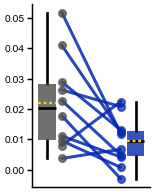

shapiro_p-value: 0.998340988145418
d,agostino_p-value: 0.9327633362564559
hedges g: 0.9807561328400024


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.572063,9,two-sided,0.030086,"[0.0, 0.02]",1.024025,2.601,0.82108


In [64]:
figname = f'{SUBJECT_TYPE}-sttc-homeo-units'
fig_p = f'{figname}.svg'
with pp.destination('figma', style=style_path):
    f, ax = acr.plots.gen_paired_boxplot(nnxr, nnxo, colors=[NNXR_GRAY, MAIN_COLOR], fsize=pp.scale(1.15, 1.4))
    ax.set_xticklabels([])
    plt.show()
    f.savefig(os.path.join(nbroot, fig_p), transparent=True, bbox_inches='tight')
diffs = nnxr - nnxo
shap_stat, shap_p = shapiro(diffs) # test the paired differences for normality
agostino_stat, agostino_p = normaltest(diffs) # test the paired differences for normality
print(f'shapiro_p-value: {shap_p}')
print(f'd,agostino_p-value: {agostino_p}')

stats = pg.ttest(nnxr, nnxo, paired=True)
# stats = pg.wilcoxon(nnxr, nnxo)
hg = pg.compute_effsize(nnxr, nnxo, paired=True, eftype='hedges')
print(f'hedges g: {hg}')

#r = acr.stats.calculate_wilx_r(stats['W-val'][0], len(nnxr))
# ==== Write Stats Results ====
acr.stats.write_stats_result(
    figname, 
    'paired_ttest',
    test_statistic=stats['T'][0],
    p_value=stats['p-val'][0],
    effect_size_method='g',
    effect_size=hg,
    review=True,
)

## ===== Write Source Data =====
source_data = pd.DataFrame({'contra_control': nnxr, 'off_induction': nnxo, 'subject': np.arange(len(nnxr))})
write_source_data(source_data, figname)
stats

In [65]:
reb_rels_fixed = {}
for subject in spike_trains.keys():
    reb_rels_fixed[subject] = {}
    for probe in ['NNXr', 'NNXo']:
        hom = sttcs[subject]['early_bl'][probe] - sttcs[subject]['circ_bl'][probe]
        mask = hom <= 0.0
        # where mask is false, set hom to nan
        hom[~mask] = np.nan
        
        eps = 1e-6
        cbl_mtx = np.arctanh(np.clip(sttcs[subject]['circ_bl'][probe], -1+eps, 1-eps))
        reb_mtx = np.arctanh(np.clip(sttcs[subject]['rebound'][probe], -1+eps, 1-eps))
        
        reb_rel = reb_mtx - cbl_mtx
        reb_rel[~mask] = np.nan
        reb_rels_fixed[subject][probe] = reb_rel
nnxo = np.array([np.nanmean(reb_rels_fixed[subject]['NNXo']) for subject in reb_rels_fixed.keys()])
nnxr = np.array([np.nanmean(reb_rels_fixed[subject]['NNXr']) for subject in reb_rels_fixed.keys()])

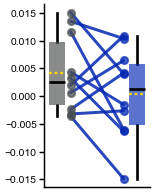

shapiro_p-value: 0.622601301091417
d,agostino_p-value: 0.5711050948125157
hedges g: 0.4621000795583615


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.298146,9,two-sided,0.226516,"[-0.0, 0.01]",0.482487,0.601,0.276537


In [66]:
figname = f'{SUBJECT_TYPE}-sttc-fixed-units'
fig_p = f'{figname}.svg'
with pp.destination('figma', style=style_path):
    f, ax = acr.plots.gen_paired_boxplot(nnxr, nnxo, colors=[NNXR_GRAY, MAIN_COLOR], fsize=pp.scale(1.15, 1.4), alphas=[0.65, 0.65])
    ax.set_xticklabels([])
    plt.show()
    #f.savefig(os.path.join(nbroot, fig_p), transparent=True, bbox_inches='tight')
diffs = nnxr - nnxo
shap_stat, shap_p = shapiro(diffs) # test the paired differences for normality
agostino_stat, agostino_p = normaltest(diffs) # test the paired differences for normality
print(f'shapiro_p-value: {shap_p}')
print(f'd,agostino_p-value: {agostino_p}')

stats = pg.ttest(nnxr, nnxo, paired=True)
# stats = pg.wilcoxon(nnxr, nnxo)
hg = pg.compute_effsize(nnxr, nnxo, paired=True, eftype='hedges')
print(f'hedges g: {hg}')

#r = acr.stats.calculate_wilx_r(stats['W-val'][0], len(nnxr))
# ==== Write Stats Results ====
acr.stats.write_stats_result(
    figname, 
    'paired_ttest',
    test_statistic=stats['T'][0],
    p_value=stats['p-val'][0],
    effect_size_method='g',
    effect_size=hg,
    review=True,
)

## ===== Write Source Data =====
source_data = pd.DataFrame({'contra_control': nnxr, 'off_induction': nnxo, 'subject': np.arange(len(nnxr))})
#write_source_data(source_data, figname)
stats


# Single Unit-Level STTC

In [67]:
cond_dfs = {}
spike_trains = {}
sttcs = {}
for subject in df_filts.keys():
    cond_dfs[subject] = {}
    times = [
        (0, 3600),
        (3600, 7200),
        (7200, 10800)
    ]
    for tt, cond in zip(times, ['early_bl', 'circ_bl', 'rebound']):
        cond_df = df_filts[subject].filter((pl.col('time')>=tt[0])&(pl.col('time')<tt[1]))
        dftimes = cond_df['time'].to_numpy()
        times_rel = dftimes - tt[0]
        cond_df = cond_df.with_columns(pl.lit(times_rel).alias('time_rel'))
        cond_dfs[subject][cond] = cond_df
for subject in df_filts.keys():
    spike_trains[subject] = {}
    for cond in cond_dfs[subject]:
        spike_trains[subject][cond] = {}
        for probe in ['NNXo', 'NNXr']:
            spike_trains[subject][cond][probe] = []
            uids = cond_dfs[subject][cond].prb(probe)['unit_id'].unique().to_numpy()
            uids = np.sort(uids)
            for uid in uids:
                spike_trains[subject][cond][probe].append(cond_dfs[subject][cond].prb(probe).filter(pl.col('unit_id') == uid)['time_rel'].to_numpy())
for subject in spike_trains.keys():
    sttcs[subject] = {}
    for cond in spike_trains[subject].keys():
        sttcs[subject][cond] = {}
        for probe in spike_trains[subject][cond].keys():
            sttcs[subject][cond][probe] = acr.sync.sttc_matrix_fast(spike_trains[subject][cond][probe], 0, 3600, .005)

In [68]:
# Homeostatically regulated unit pairs
ubu_hom = {}
ubudf_hom = {}
ubudf_hom['NNXo'] = []
ubudf_hom['NNXr'] = []
for subject in spike_trains.keys():
    ubu_hom[subject] = {}
    for probe in ['NNXo', 'NNXr']:
        hom = sttcs[subject]['early_bl'][probe] - sttcs[subject]['circ_bl'][probe]
        mask = hom > 0.0
        ebl = sttcs[subject]['early_bl'][probe]
        cbl = sttcs[subject]['circ_bl'][probe]
        reb = sttcs[subject]['rebound'][probe]
        ebl[~mask] = np.nan
        cbl[~mask] = np.nan
        reb[~mask] = np.nan
        cbl_df = acr.stats.get_positions_and_values_df(cbl, 'sttc_late', subject)
        reb_df = acr.stats.get_positions_and_values_df(reb, 'sttc_rebound', subject)
        reb_df = reb_df.merge(cbl_df, on=['mouse', 'unit_i', 'unit_j'], how='inner')
        reb_df['probe'] = probe
        ubudf_hom[probe].append(reb_df)
ubudf_hom['NNXo'] = pd.concat(ubudf_hom['NNXo'])
ubudf_hom['NNXr'] = pd.concat(ubudf_hom['NNXr'])
main_ubudf_hom = pd.concat(ubudf_hom.values())
main_ubudf_hom['probe'] = main_ubudf_hom['probe'].replace({'NNXo': 'optrode', 'NNXr': 'contra'})
dz = acr.stats.fisher_z(main_ubudf_hom["sttc_rebound"].to_numpy()) - acr.stats.fisher_z(main_ubudf_hom["sttc_late"].to_numpy())
main_ubudf_hom["dz"] = dz

In [69]:
main_ubudf_hom.to_csv('dfsom.csv', index=False)

In [ ]:
out, idata = acr.stats.pooled_dyadic_probe_effect_pymc(main_ubudf_hom)

In [70]:
cond_dfs = {}
spike_trains = {}
sttcs = {}
for subject in df_filts.keys():
    cond_dfs[subject] = {}
    times = [
        (0, 3600),
        (3600, 7200),
        (7200, 10800)
    ]
    for tt, cond in zip(times, ['early_bl', 'circ_bl', 'rebound']):
        cond_df = df_filts[subject].filter((pl.col('time')>=tt[0])&(pl.col('time')<tt[1]))
        dftimes = cond_df['time'].to_numpy()
        times_rel = dftimes - tt[0]
        cond_df = cond_df.with_columns(pl.lit(times_rel).alias('time_rel'))
        cond_dfs[subject][cond] = cond_df
for subject in df_filts.keys():
    spike_trains[subject] = {}
    for cond in cond_dfs[subject]:
        spike_trains[subject][cond] = {}
        for probe in ['NNXo', 'NNXr']:
            spike_trains[subject][cond][probe] = []
            uids = cond_dfs[subject][cond].prb(probe)['unit_id'].unique().to_numpy()
            uids = np.sort(uids)
            for uid in uids:
                spike_trains[subject][cond][probe].append(cond_dfs[subject][cond].prb(probe).filter(pl.col('unit_id') == uid)['time_rel'].to_numpy())
for subject in spike_trains.keys():
    sttcs[subject] = {}
    for cond in spike_trains[subject].keys():
        sttcs[subject][cond] = {}
        for probe in spike_trains[subject][cond].keys():
            sttcs[subject][cond][probe] = acr.sync.sttc_matrix_fast(spike_trains[subject][cond][probe], 0, 3600, .005)

In [71]:
# FIXED unit pairs
ubu_fix = {}
ubudf_fix = {}
ubudf_fix['NNXo'] = []
ubudf_fix['NNXr'] = []
for subject in spike_trains.keys():
    ubu_fix[subject] = {}
    for probe in ['NNXo', 'NNXr']:
        print(subject, probe)
        hom = sttcs[subject]['early_bl'][probe] - sttcs[subject]['circ_bl'][probe]
        mask = hom <= 0.0
        ebl = sttcs[subject]['early_bl'][probe]
        cbl = sttcs[subject]['circ_bl'][probe]
        reb = sttcs[subject]['rebound'][probe]
        ebl[~mask] = np.nan
        cbl[~mask] = np.nan
        reb[~mask] = np.nan
        cbl_df = acr.stats.get_positions_and_values_df(cbl, 'sttc_late', subject)
        reb_df = acr.stats.get_positions_and_values_df(reb, 'sttc_rebound', subject)
        reb_df = reb_df.merge(cbl_df, on=['mouse', 'unit_i', 'unit_j'], how='inner')
        reb_df['probe'] = probe
        ubudf_fix[probe].append(reb_df)
ubudf_fix['NNXo'] = pd.concat(ubudf_fix['NNXo'])
ubudf_fix['NNXr'] = pd.concat(ubudf_fix['NNXr'])
main_ubudf_fix = pd.concat(ubudf_fix.values())
main_ubudf_fix['probe'] = main_ubudf_fix['probe'].replace({'NNXo': 'optrode', 'NNXr': 'contra'})
dz = acr.stats.fisher_z(main_ubudf_fix["sttc_rebound"].to_numpy()) - acr.stats.fisher_z(main_ubudf_fix["sttc_late"].to_numpy())
main_ubudf_fix["dz"] = dz

ACR_25 NNXo
ACR_25 NNXr
ACR_26 NNXo
ACR_26 NNXr
ACR_29 NNXo
ACR_29 NNXr
ACR_30 NNXo
ACR_30 NNXr
ACR_35 NNXo
ACR_35 NNXr
ACR_37 NNXo
ACR_37 NNXr
ACR_39 NNXo
ACR_39 NNXr
ACR_40 NNXo
ACR_40 NNXr
ACR_41 NNXo
ACR_41 NNXr
ACR_44 NNXo
ACR_44 NNXr


In [72]:
main_ubudf_fix.to_csv('dfsom_fix.csv', index=False)

In [25]:
out_fix, idata_fix = acr.stats.pooled_dyadic_probe_effect_pymc(main_ubudf_fix)

Output()

14-Feb-26 13:26:19 | ERROR | There were 33 divergences after tuning. Increase `target_accept` or reparameterize.


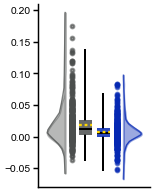

In [73]:
fig_name = f'{SUBJECT_TYPE}-sttc-ALL-homeo_units'
fig_path = os.path.join(nbroot, f'{fig_name}.svg')
with pp.destination('figma', style=style_path):
    f, ax = plt.subplots(1, 1, figsize=pp.scale(1.15, 1.4))
    op_dz = main_ubudf_hom.loc[main_ubudf_hom['probe'] == 'optrode']['dz'].to_numpy()
    cr_dz = main_ubudf_hom.loc[main_ubudf_hom['probe'] == 'contra']['dz'].to_numpy()

    op_mean = np.mean(op_dz)
    cr_mean = np.mean(cr_dz)
    op_std = np.std(op_dz)
    cr_std = np.std(cr_dz)

    #plot the mean as a point with std error bars
    acr.plots.add_boxplot(ax, data=cr_dz, positions=[0.46], color=NNXR_GRAY)
    acr.plots.add_boxplot(ax, data=op_dz, positions=[0.54], color=MAIN_COLOR)
    acr.plots.add_data_points(ax, data=cr_dz, x_pos=0.4, color=NNXR_GRAY, s=30, alpha=0.6)
    acr.plots.add_data_points(ax, data=op_dz, x_pos=0.6, color=MAIN_COLOR, s=30, alpha=0.6)
    
    # add kde-style density plot for cr_dz at x=0.35
    acr.plots.add_vertical_kde(ax, data=cr_dz, x_pos=0.37, color=NNXR_GRAY, width=0.08, alpha=0.4)
    # add kde-style density plot for op_dz at x=0.65
    acr.plots.add_vertical_kde(ax, data=op_dz, x_pos=0.63, color=MAIN_COLOR, width=0.08, alpha=0.4, flip=True)

    ax.set_xlim(0.25, 0.75)
    #ax.set_ylim(-.07, 0.19)
    ax.set_xticklabels([])
    #ax.set_yticklabels([])
    plt.show()
    #f.savefig(fig_path, transparent=True, bbox_inches='tight')

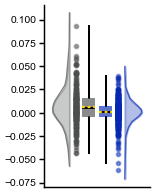

In [74]:
fig_name = f'{SUBJECT_TYPE}-sttc-ALL-FIX_units'
fig_path = os.path.join(nbroot, f'{fig_name}.svg')
with pp.destination('figma', style=style_path):
    f, ax = plt.subplots(1, 1, figsize=pp.scale(1.15, 1.4))
    op_dz = main_ubudf_fix.loc[main_ubudf_fix['probe'] == 'optrode']['dz'].to_numpy()
    cr_dz = main_ubudf_fix.loc[main_ubudf_fix['probe'] == 'contra']['dz'].to_numpy()

    op_mean = np.mean(op_dz)
    cr_mean = np.mean(cr_dz)
    op_std = np.std(op_dz)
    cr_std = np.std(cr_dz)

    #plot the mean as a point with std error bars
    acr.plots.add_boxplot(ax, data=cr_dz, positions=[0.46], color=NNXR_GRAY, alpha=0.65)
    acr.plots.add_boxplot(ax, data=op_dz, positions=[0.54], color=MAIN_COLOR, alpha=0.65)
    acr.plots.add_data_points(ax, data=cr_dz, x_pos=0.4, color=NNXR_GRAY, s=30, alpha=0.45)
    acr.plots.add_data_points(ax, data=op_dz, x_pos=0.6, color=MAIN_COLOR, s=30, alpha=0.45)
    
    # add kde-style density plot for cr_dz at x=0.35
    acr.plots.add_vertical_kde(ax, data=cr_dz, x_pos=0.37, color=NNXR_GRAY, width=0.08, alpha=0.3)
    # add kde-style density plot for op_dz at x=0.65
    acr.plots.add_vertical_kde(ax, data=op_dz, x_pos=0.63, color=MAIN_COLOR, width=0.08, alpha=0.3, flip=True)

    ax.set_xlim(0.25, 0.75)
    #ax.set_ylim(-.07, 0.19)
    ax.set_xticklabels([])
    #ax.set_yticklabels([])
    plt.show()
    #f.savefig(fig_path, transparent=True, bbox_inches='tight')

# check FR

In [138]:
dfs_labelled = []
for subject in df_filts.keys():
    df = df_filts[subject]
    df = df.with_columns(pl.lit(subject).alias('subject'))
    dfs_labelled.append(df)
full_df = pl.concat(dfs_labelled)

In [140]:
frdf = full_df.group_by(['subject','condition', 'probe', 'unit_id']).agg(pl.count())
frdf = frdf.with_columns((pl.col('count')/3600).alias('fr'))

In [142]:
frdf = frdf.sort(['subject', 'condition', 'probe', 'unit_id'])
frdf = frdf.pivot(index=['subject', 'unit_id', 'probe'], columns='condition', values='fr')

In [144]:
frdf = frdf.with_columns((pl.col('rebound')/pl.col('circ-bl')).alias('reb_rel_fr'))

In [147]:
frmeans = frdf.group_by(['subject', 'probe']).agg(pl.mean('reb_rel_fr')).sort(['subject', 'probe'])

# STTC Schematic -  Visualize All Unit Pairs

In [272]:
nbroot = os.path.join(PAPER_FIGURE_ROOT, 'response_to_review', 'single_unit_sync', 'schem')
if not os.path.exists(nbroot):
    os.mkdir(nbroot)

In [273]:
import spikeinterface.widgets as sw

In [275]:
probe = 'NNXr'

In [276]:
analyzer = ans['ACR_26'][probe]

In [277]:
unit_ids_good = df_filts['ACR_26'].filter(pl.col('probe') == probe)['unit_id'].unique().to_numpy()
unit_ids_all = analyzer.unit_ids
ext_wf = analyzer.get_extension("waveforms")

In [278]:
unit_locs = analyzer.get_extension("unit_locations").get_data()
# unit_locs is (n_units, ndim). For most probes ndim=2: columns are (x, y) in µm.

In [279]:

unit_depths_um = unit_locs[:, 1]  # y-coordinate == “depth” in probe coords

# handy mapping if you want a dict:
depth_by_unit = dict(zip(unit_ids_all, unit_depths_um))

In [280]:
unit_depths_um.min(), unit_depths_um.max()

(np.float64(75.06707747011767), np.float64(769.5622513373334))

In [281]:
alphas = {}
depth_min = 0
alpha_min = 0.5
depth_max = 800
alpha_max = 1.0
for unid in unit_ids_good:
    unit_depth = depth_by_unit[unid]
    alpha = alpha_min + (unit_depth - depth_min)/(depth_max - depth_min)*(alpha_max - alpha_min)
    print(unit_depth, alpha)
    alphas[unid] = alpha

769.5622513373334 0.9809764070858333
544.1525465001477 0.8400953415625922
459.702501334735 0.7873140633342094
406.5722589199824 0.754107661824989
345.8254322915816 0.7161408951822386
326.8140619483791 0.704258788717737
307.94452858767704 0.6924653303672982
297.83846265848695 0.6861490391615543
243.22843794307747 0.6520177737144234
243.72083956384012 0.6523255247274
192.75736783617768 0.620473354897611
135.87520440385416 0.5849220027524089
75.06707747011767 0.5469169234188236


In [282]:
alphas_sem = {}
depth_min = 0
alpha_min = 0.2
depth_max = 800
alpha_max = 0.5
for unid in unit_ids_good:
    unit_depth = depth_by_unit[unid]
    alpha = alpha_min + (unit_depth - depth_min)/(depth_max - depth_min)*(alpha_max - alpha_min)
    print(unit_depth, alpha)
    alphas_sem[unid] = alpha

769.5622513373334 0.4885858442515
544.1525465001477 0.40405720493755537
459.702501334735 0.3723884380005257
406.5722589199824 0.35246459709499345
345.8254322915816 0.3296845371093431
326.8140619483791 0.32255527323064215
307.94452858767704 0.3154791982203789
297.83846265848695 0.3116894234969326
243.22843794307747 0.29121066422865405
243.72083956384012 0.29139531483644004
192.75736783617768 0.27228401293856663
135.87520440385416 0.2509532016514453
75.06707747011767 0.22815015405129413


In [283]:
ax.get_xlim()

(np.float64(-3.5500000000000003), np.float64(74.55))

In [ ]:
for unid in unit_ids_good:
    wf = ext_wf.get_waveforms_one_unit(unid)
    min_wf_ix = wf.mean(axis=0).min(axis=0).argmin()
    with pp.destination('figma', style=style_path):
        f, ax = plt.subplots(1, 1, figsize=pp.scale(0.27, 0.27))
        wf_all = wf[:, :, min_wf_ix]
        wfmean = wf_all.mean(axis=0)
        wfsem = wf_all.std(axis=0)/np.sqrt(wf_all.shape[0])
        ax.plot(wfmean, alpha=alphas[unid], linewidth=0.7, color='black')
        ax.fill_between(range(wfmean.shape[0]), wfmean-wfsem, wfmean+wfsem, alpha=alphas_sem[unid], color='gray')
        #ax.set_ylim(-12, 3)
        # Remove all spines, ticks, and labels
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ymin = ax.get_ylim()[0]
        y_start = ymin + 1
        ax.vlines(0, y_start, y_start+2, linewidth=0.35)
        ax.hlines(y_start, 0, 10, linewidth=0.35)
        #ax.vlines(60, -3, -1, linewidth=0.5)
        #ax.hlines(-3, 60, 70, linewidth=0.5)
        print(ax.get_ylim())
        f.savefig(os.path.join(nbroot, f'{probe}_{unid}_labelled.svg'), transparent=True, bbox_inches='tight')
        plt.show()

In [285]:
ebl = sttcs['ACR_26']['early_bl'][probe]
cbl = sttcs['ACR_26']['circ_bl'][probe]


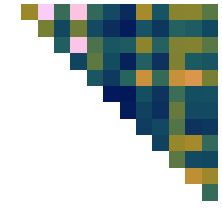

In [286]:
fig_name = f'ebl_{probe}'
fig_path = os.path.join(nbroot, f'{fig_name}.svg')
with pp.destination('figma', style=style_path):
    f, ax = plt.subplots(1, 1, figsize=pp.scale(1.6, 1.6))
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(ebl, cmap=scm.batlow, vmin=0, vmax=0.235)
    plt.show()
    f.savefig(fig_path, transparent=True, bbox_inches='tight')

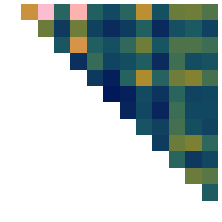

In [287]:
fig_name = f'cbl_{probe}'
fig_path = os.path.join(nbroot, f'{fig_name}.svg')
with pp.destination('figma', style=style_path):
    f, ax = plt.subplots(1, 1, figsize=pp.scale(1.6, 1.6))
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(cbl, cmap=scm.batlow, vmin=0, vmax=0.235)
    plt.show()
    f.savefig(fig_path, transparent=True, bbox_inches='tight')

In [304]:
with pp.destination('figma', style=style_path):
    fig, ax = plt.subplots(1, 1, figsize=pp.scale(1.495, 0.3))
    gradient = np.linspace(0, 1, 256).reshape(1, -1)
    ax.imshow(gradient, aspect='auto', cmap=scm.batlow)
    ax.set_axis_off()
    #plt.tight_layout()
    ax.set_position([0, 0, 1, 1])  # fill entire figure
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
    plt.margins(0, 0)
    plt.show()
    fig_path = os.path.join(nbroot, f'batlow_colorbar.svg')
    fig.savefig(fig_path, transparent=True, bbox_inches='tight')

In [305]:
bldiff = ebl-cbl
bldiff_discrete = np.where(np.isnan(bldiff), np.nan, np.where(bldiff > 0, 10, -10))
bldiff_discrete

array([[ nan, -10.,  10.,  10.,  10.,  10.,  10., -10., -10.,  10.,  10.,
         10.,  10.],
       [ nan,  nan,  10.,  10.,  10.,  10.,  10., -10., -10.,  10.,  10.,
         10.,  10.],
       [ nan,  nan,  nan,  10.,  10.,  10.,  10., -10.,  10.,  10.,  10.,
         10.,  10.],
       [ nan,  nan,  nan,  nan,  10.,  10.,  10., -10.,  10.,  10.,  10.,
         10.,  10.],
       [ nan,  nan,  nan,  nan,  nan,  10.,  10.,  10.,  10.,  10.,  10.,
         10.,  10.],
       [ nan,  nan,  nan,  nan,  nan,  nan,  10., -10.,  10., -10.,  10.,
         10.,  10.],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan, -10., -10.,  10.,  10.,
         10.,  10.],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan, -10.,  10.,  10.,
        -10., -10.],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  10.,  10.,
         10.,  10.],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  10.,
         10., -10.],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan, 

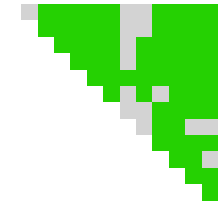

In [306]:
fig_name = f'homeo_pairs_{probe}'
fig_path = os.path.join(nbroot, f'{fig_name}.svg')
# Create colormap from light gray to bright green
from matplotlib.colors import LinearSegmentedColormap
gray_to_green = LinearSegmentedColormap.from_list(
    'gray_to_green', 
    ['#D3D3D3', '#25d102']  # light gray to bright green
)
with pp.destination('figma', style=style_path):
    f, ax = plt.subplots(1, 1, figsize=pp.scale(1.6, 1.6))
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(bldiff_discrete, cmap=gray_to_green, vmin=-.1, vmax=0.1)
    plt.show()
    f.savefig(fig_path, transparent=True, bbox_inches='tight')

In [353]:
probe = 'NNXo'

In [354]:
analyzer = ans['ACR_26'][probe]

In [355]:
unit_ids_good = df_filts['ACR_26'].filter(pl.col('probe') == probe)['unit_id'].unique().to_numpy()
unit_ids_all = analyzer.unit_ids
ext_wf = analyzer.get_extension("waveforms")

In [356]:
unit_locs = analyzer.get_extension("unit_locations").get_data()
# unit_locs is (n_units, ndim). For most probes ndim=2: columns are (x, y) in µm.

In [357]:

unit_depths_um = unit_locs[:, 1]  # y-coordinate == “depth” in probe coords

# handy mapping if you want a dict:
depth_by_unit = dict(zip(unit_ids_all, unit_depths_um))

In [358]:
unit_depths_um.min(), unit_depths_um.max()

(np.float64(65.75486962895647), np.float64(792.6087881114707))

In [359]:
alphas = {}
depth_min = 0
alpha_min = 0.5
depth_max = 800
alpha_max = 1.0
for unid in unit_ids_good:
    unit_depth = depth_by_unit[unid]
    alpha = alpha_min + (unit_depth - depth_min)/(depth_max - depth_min)*(alpha_max - alpha_min)
    print(unit_depth, alpha)
    alphas[unid] = alpha

792.6087881114707 0.9953804925696692
716.2565190598464 0.947660324412404
616.8447437607667 0.8855279648504792
528.496446818025 0.8303102792612655
455.6578622130897 0.784786163883181
462.43577867819516 0.789022361673872
391.4925204119227 0.7446828252574517
325.1113046847202 0.7031945654279501
259.8243170296876 0.6623901981435547
209.15950860654314 0.6307246928790895
166.0835706174688 0.603802231635918
164.41623613511814 0.6027601475844488
65.75486962895647 0.5410967935180978


In [360]:
alphas_sem = {}
depth_min = 0
alpha_min = 0.2
depth_max = 800
alpha_max = 0.5
for unid in unit_ids_good:
    unit_depth = depth_by_unit[unid]
    alpha = alpha_min + (unit_depth - depth_min)/(depth_max - depth_min)*(alpha_max - alpha_min)
    print(unit_depth, alpha)
    alphas_sem[unid] = alpha

792.6087881114707 0.49722829554180153
716.2565190598464 0.4685961946474424
616.8447437607667 0.4313167789102875
528.496446818025 0.3981861675567594
455.6578622130897 0.37087169832990863
462.43577867819516 0.3734134170043232
391.4925204119227 0.346809695154471
325.1113046847202 0.3219167392567701
259.8243170296876 0.29743411888613286
209.15950860654314 0.2784348157274537
166.0835706174688 0.2622813389815508
164.41623613511814 0.2616560885506693
65.75486962895647 0.2246580761108587


In [361]:
for unid in unit_ids_good:
    wf = ext_wf.get_waveforms_one_unit(unid)
    min_wf_ix = wf.mean(axis=0).min(axis=0).argmin()
    with pp.destination('figma', style=style_path):
        f, ax = plt.subplots(1, 1, figsize=pp.scale(0.27, 0.27))
        wf_all = wf[:, :, min_wf_ix]
        wfmean = wf_all.mean(axis=0)
        wfsem = wf_all.std(axis=0)/np.sqrt(wf_all.shape[0])
        ax.plot(wfmean, alpha=alphas[unid], linewidth=0.7, color=SOM_BLUE)
        ax.fill_between(range(wfmean.shape[0]), wfmean-wfsem, wfmean+wfsem, alpha=alphas_sem[unid], color=SOM_BLUE)
        #ax.set_ylim(-12, 3)
        # Remove all spines, ticks, and labels
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ymin = ax.get_ylim()[0]
        y_start = ymin + 1
        ax.vlines(0, y_start, y_start+2, linewidth=0.35)
        ax.hlines(y_start, 0, 10, linewidth=0.35)
        #ax.vlines(60, -3, -1, linewidth=0.5)
        #ax.hlines(-3, 60, 70, linewidth=0.5)
        print(ax.get_ylim())
        f.savefig(os.path.join(nbroot, f'{probe}_{unid}_labelled.svg'), transparent=True, bbox_inches='tight')
        plt.show()

(np.float64(-6.325950101605477), np.float64(1.4804230854284313))


(np.float64(-8.123301578803323), np.float64(2.339028825872986))


(np.float64(-6.048335803037276), np.float64(1.2528401723771885))


(np.float64(-5.138433689996875), np.float64(0.7751134422808487))


(np.float64(-7.016764445789296), np.float64(1.2738687573380807))


(np.float64(-11.243994511077993), np.float64(4.2885003913080295))


(np.float64(-6.46416868382258), np.float64(1.566872379342168))


(np.float64(-4.683707618103102), np.float64(1.3555258077085952))


(np.float64(-10.005850933141751), np.float64(3.0496235002075958))


(np.float64(-8.56939457903972), np.float64(2.331359922289059))


(np.float64(-13.873102941256771), np.float64(4.150511866774625))


(np.float64(-7.356766317564764), np.float64(2.0616638129632885))


(np.float64(-5.614456103923926), np.float64(1.1924475529336223))


In [362]:
ebl = sttcs['ACR_26']['early_bl'][probe]
cbl = sttcs['ACR_26']['circ_bl'][probe]


In [363]:
np.nanmax(ebl), np.nanmax(cbl)

(np.float64(0.26162052416195203), np.float64(0.26874984966267706))

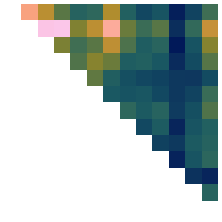

In [364]:
fig_name = f'ebl_{probe}'
fig_path = os.path.join(nbroot, f'{fig_name}.svg')
with pp.destination('figma', style=style_path):
    f, ax = plt.subplots(1, 1, figsize=pp.scale(1.6, 1.6))
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(ebl, cmap=scm.batlow, vmin=0, vmax=0.27)
    plt.show()
    f.savefig(fig_path, transparent=True, bbox_inches='tight')

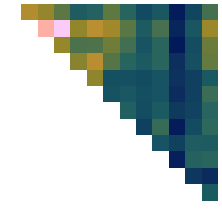

In [365]:
fig_name = f'cbl_{probe}'
fig_path = os.path.join(nbroot, f'{fig_name}.svg')
with pp.destination('figma', style=style_path):
    f, ax = plt.subplots(1, 1, figsize=pp.scale(1.6, 1.6))
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(cbl, cmap=scm.batlow, vmin=0, vmax=0.27)
    plt.show()
    f.savefig(fig_path, transparent=True, bbox_inches='tight')

In [366]:
bldiff = ebl-cbl
bldiff_discrete = np.where(np.isnan(bldiff), np.nan, np.where(bldiff > 0, 10, -10))
bldiff_discrete

array([[ nan,  10.,  10., -10.,  10.,  10.,  10., -10., -10., -10.,  10.,
        -10., -10.],
       [ nan,  nan,  10., -10., -10.,  10.,  10.,  10.,  10.,  10.,  10.,
         10.,  10.],
       [ nan,  nan,  nan, -10., -10.,  10.,  10.,  10.,  10., -10., -10.,
         10.,  10.],
       [ nan,  nan,  nan,  nan, -10., -10.,  10., -10.,  10., -10., -10.,
        -10., -10.],
       [ nan,  nan,  nan,  nan,  nan, -10.,  10.,  10., -10., -10.,  10.,
        -10., -10.],
       [ nan,  nan,  nan,  nan,  nan,  nan,  10., -10.,  10., -10.,  10.,
         10., -10.],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  10.,  10.,  10.,  10.,
         10.,  10.],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  10., -10.,  10.,
         10., -10.],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan, -10., -10.,
        -10.,  10.],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  10.,
        -10.,  10.],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan, 

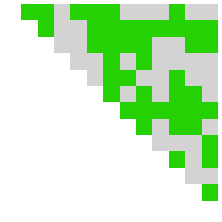

In [367]:
fig_name = f'homeo_pairs_{probe}'
fig_path = os.path.join(nbroot, f'{fig_name}.svg')
# Create colormap from light gray to bright green
from matplotlib.colors import LinearSegmentedColormap
gray_to_green = LinearSegmentedColormap.from_list(
    'gray_to_green', 
    ['#D3D3D3', '#25d102']  # light gray to bright green
)
with pp.destination('figma', style=style_path):
    f, ax = plt.subplots(1, 1, figsize=pp.scale(1.6, 1.6))
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(bldiff_discrete, cmap=gray_to_green, vmin=-.1, vmax=0.1)
    plt.show()
    f.savefig(fig_path, transparent=True, bbox_inches='tight')

In [375]:
np.nanmin(reb_rels_hom['ACR_26']['NNXo']), np.nanmax(reb_rels_hom['ACR_26']['NNXo'])

(np.float64(-0.020079215029416675), np.float64(0.08358150068812202))

In [376]:
np.nanmin(reb_rels_hom['ACR_26']['NNXr']), np.nanmax(reb_rels_hom['ACR_26']['NNXr'])

(np.float64(-0.02377090478759606), np.float64(0.15657752996928476))

In [ ]:
from matplotlib.colors import TwoSlopeNorm
cmap = modified_coolwarm_low(low=SOM_BLUE)
norm = TwoSlopeNorm(vmin=-0.025, vcenter=0, vmax=0.15)

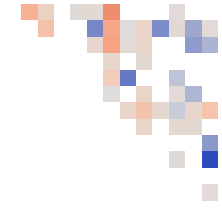

In [387]:
probe = 'NNXo'
fig_name = f'reb_rels_HOM__{probe}'
fig_path = os.path.join(nbroot, f'{fig_name}.svg')
with pp.destination('figma', style=style_path):
    f, ax = plt.subplots(1, 1, figsize=pp.scale(1.6, 1.6))
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(reb_rels_hom['ACR_26'][probe], cmap=cmap, norm=norm)
    plt.show()
    f.savefig(fig_path, transparent=True, bbox_inches='tight')

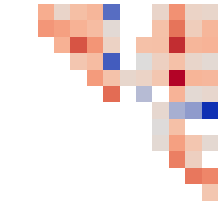

In [388]:
probe = 'NNXr'
fig_name = f'reb_rels_HOM__{probe}'
fig_path = os.path.join(nbroot, f'{fig_name}.svg')
with pp.destination('figma', style=style_path):
    f, ax = plt.subplots(1, 1, figsize=pp.scale(1.6, 1.6))
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(reb_rels_hom['ACR_26'][probe], cmap=cmap, norm=norm)
    plt.show()
    f.savefig(fig_path, transparent=True, bbox_inches='tight')

In [421]:
with pp.destination('figma', style=style_path):
    fig, ax = plt.subplots(1, 1, figsize=pp.scale(1.495, 0.3))
    gradient = np.linspace(0, 1, 256).reshape(1, -1)
    ax.imshow(gradient, aspect='auto', cmap=cmap)
    ax.set_axis_off()
    #plt.tight_layout()
    ax.set_position([0, 0, 1, 1])  # fill entire figure
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
    plt.margins(0, 0)
    plt.show()
    fig_path = os.path.join(nbroot, f'coolwarm_colorbar.svg')
    fig.savefig(fig_path, transparent=True, bbox_inches='tight')

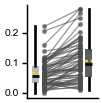

In [418]:
subject = 'ACR_26'
probe = 'NNXr'
fig_name = f'{subject}__{probe}_cbl_reb_boxplot'
fig_path = os.path.join(nbroot, f'{fig_name}.svg')
hom = sttcs[subject]['early_bl'][probe] - sttcs[subject]['circ_bl'][probe]
mask = hom > 0.0
# where mask is false, set hom to nan
hom[~mask] = np.nan

eps = 1e-6
cbl_mtx = np.arctanh(np.clip(sttcs[subject]['circ_bl'][probe], -1+eps, 1-eps))
reb_mtx = np.arctanh(np.clip(sttcs[subject]['rebound'][probe], -1+eps, 1-eps))

cbl_mtx[~mask] = np.nan
reb_mtx[~mask] = np.nan
cbl_flat = cbl_mtx.flatten()[~np.isnan(cbl_mtx.flatten())]
reb_flat = reb_mtx.flatten()[~np.isnan(reb_mtx.flatten())]
with pp.destination('figma', style=style_path):
    f, ax = plt.subplots(1, 1, figsize=pp.scale(0.8, 0.8))
    f, ax = acr.plots.gen_paired_boxplot(cbl_flat, reb_flat, ax=ax, colors=[NNXR_GRAY, NNXR_GRAY], alphas=[0.4, 0.9], lineplot_alpha=0.6, scatter_alpha=0.6, lineplot_width=1.8, dot_size=20, widths=0.04)
    ax.set_xticklabels([])
    plt.show()
    f.savefig(fig_path, transparent=True, bbox_inches='tight')

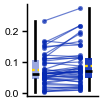

In [420]:
subject = 'ACR_26'
probe = 'NNXo'
fig_name = f'{subject}__{probe}_cbl_reb_boxplot'
fig_path = os.path.join(nbroot, f'{fig_name}.svg')
hom = sttcs[subject]['early_bl'][probe] - sttcs[subject]['circ_bl'][probe]
mask = hom > 0.0
# where mask is false, set hom to nan
hom[~mask] = np.nan

eps = 1e-6
cbl_mtx = np.arctanh(np.clip(sttcs[subject]['circ_bl'][probe], -1+eps, 1-eps))
reb_mtx = np.arctanh(np.clip(sttcs[subject]['rebound'][probe], -1+eps, 1-eps))

cbl_mtx[~mask] = np.nan
reb_mtx[~mask] = np.nan
cbl_flat = cbl_mtx.flatten()[~np.isnan(cbl_mtx.flatten())]
reb_flat = reb_mtx.flatten()[~np.isnan(reb_mtx.flatten())]
with pp.destination('figma', style=style_path):
    f, ax = plt.subplots(1, 1, figsize=pp.scale(0.8, 0.8))
    f, ax = acr.plots.gen_paired_boxplot(cbl_flat, reb_flat, ax=ax, colors=[SOM_BLUE, SOM_BLUE], alphas=[0.4, 0.9], lineplot_alpha=0.6, scatter_alpha=0.6, lineplot_width=1.8, dot_size=20, widths=0.04)
    ax.set_xticklabels([])
    plt.show()
    f.savefig(fig_path, transparent=True, bbox_inches='tight')

# All subject Vis

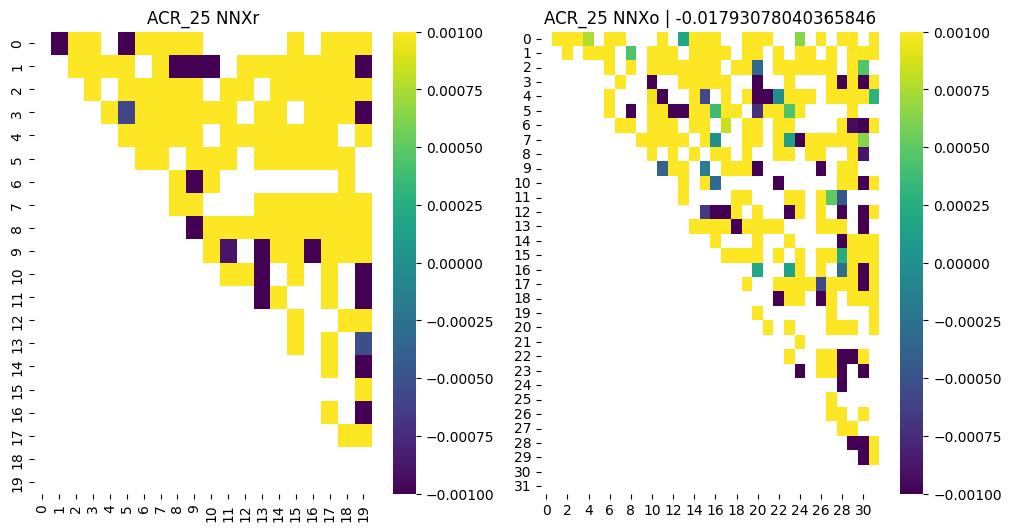

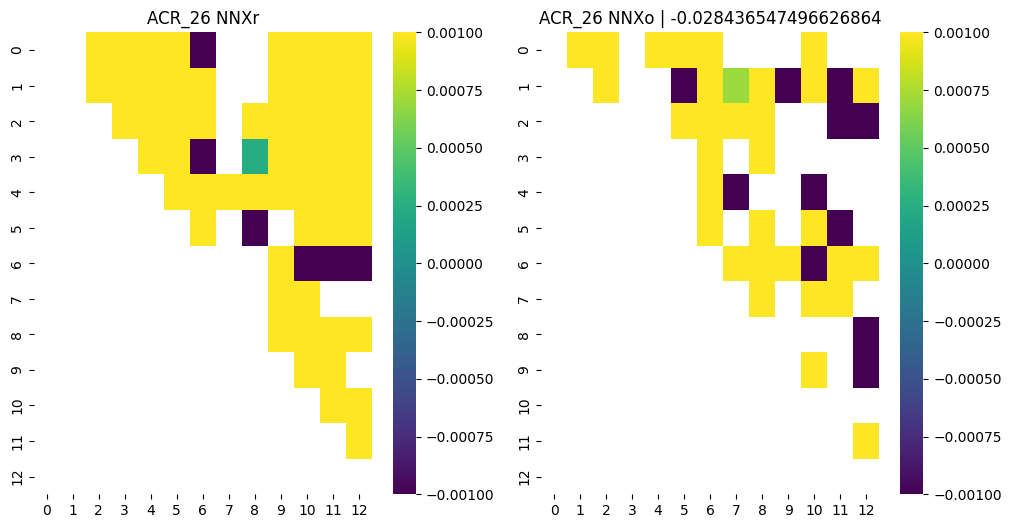

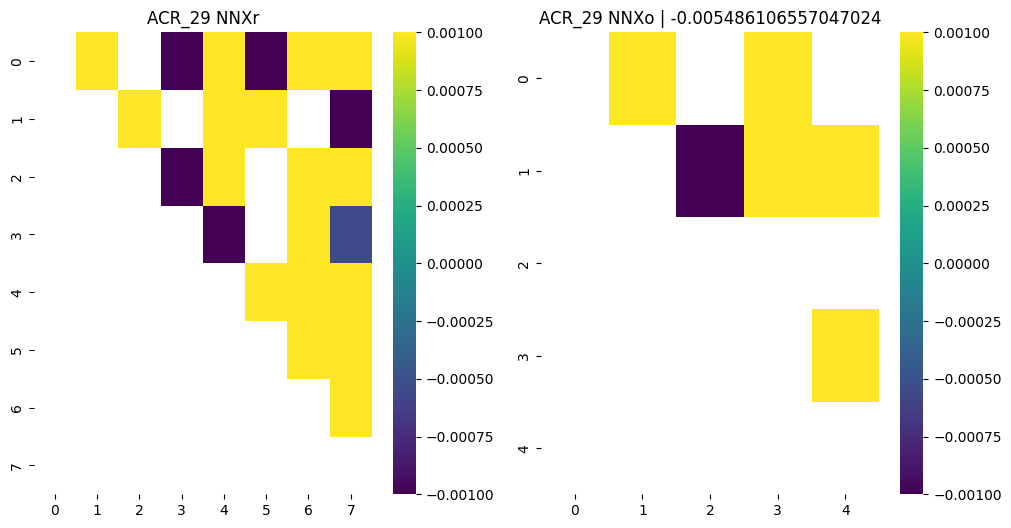

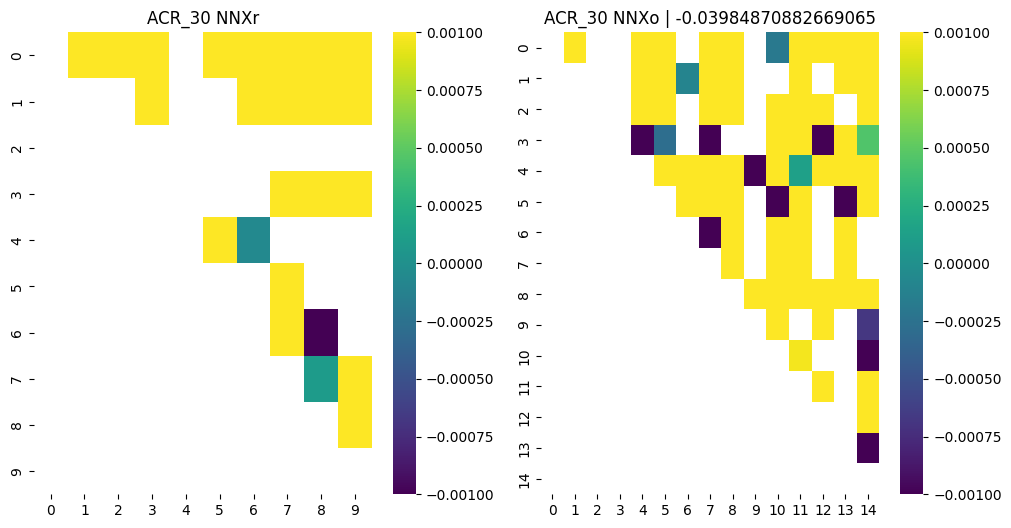

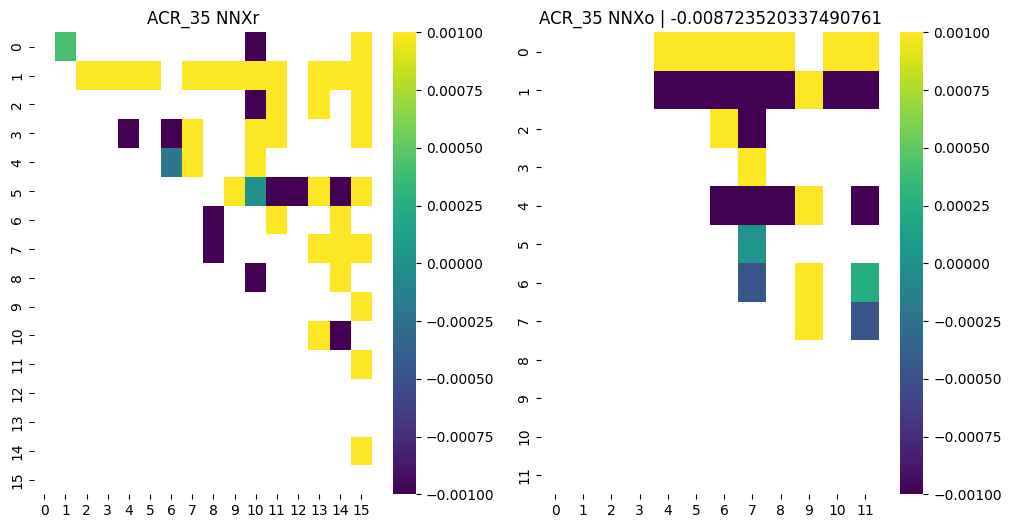

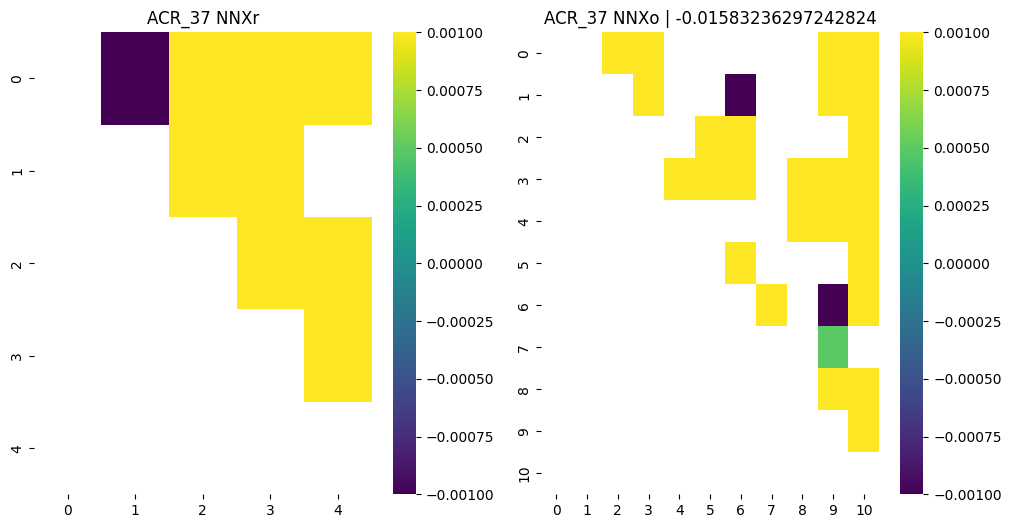

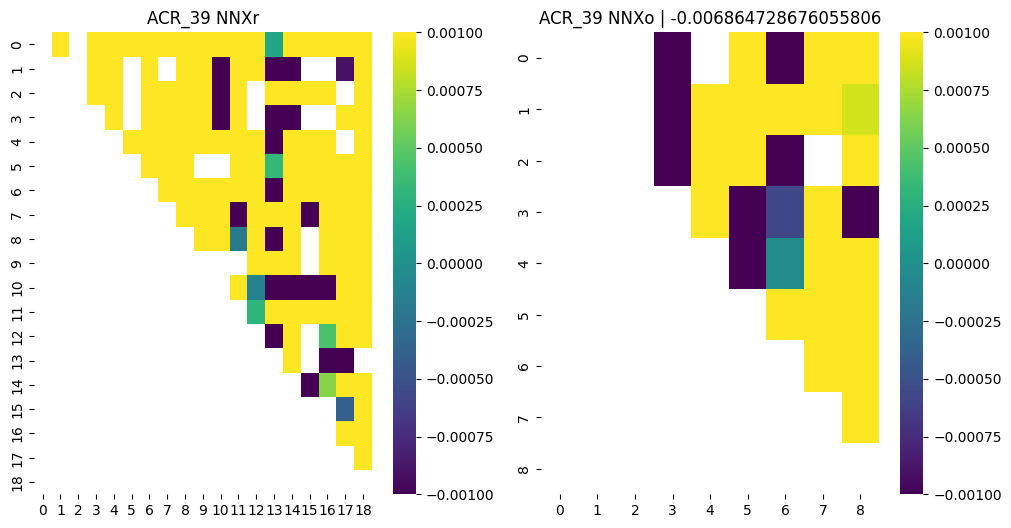

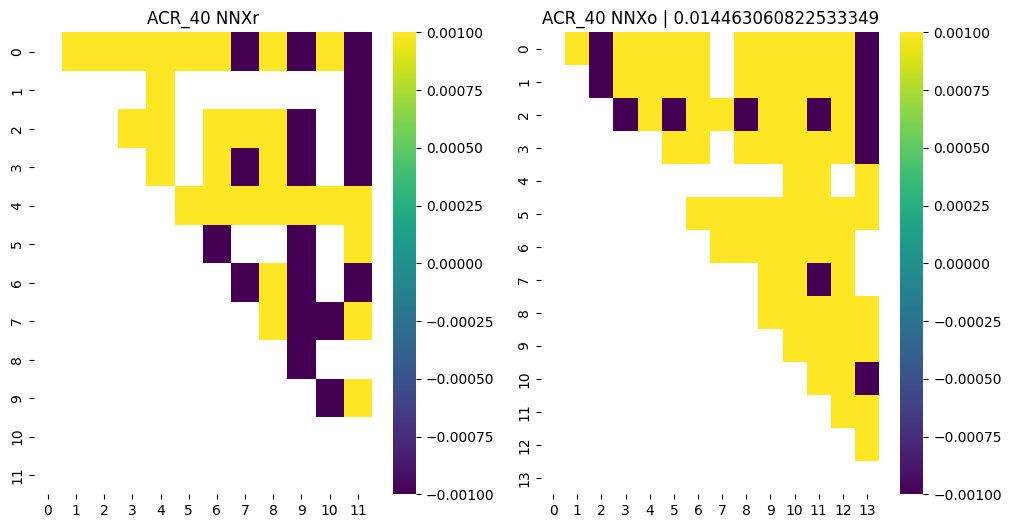

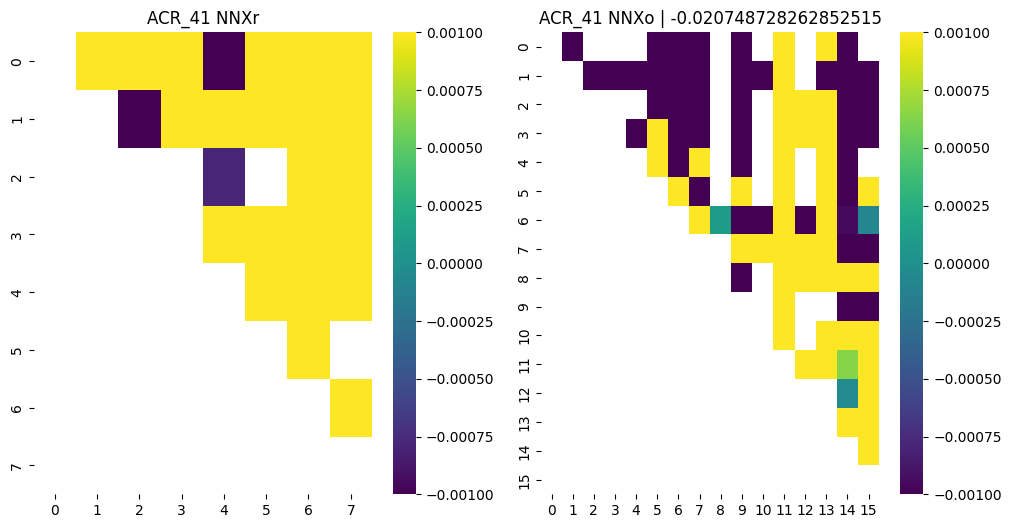

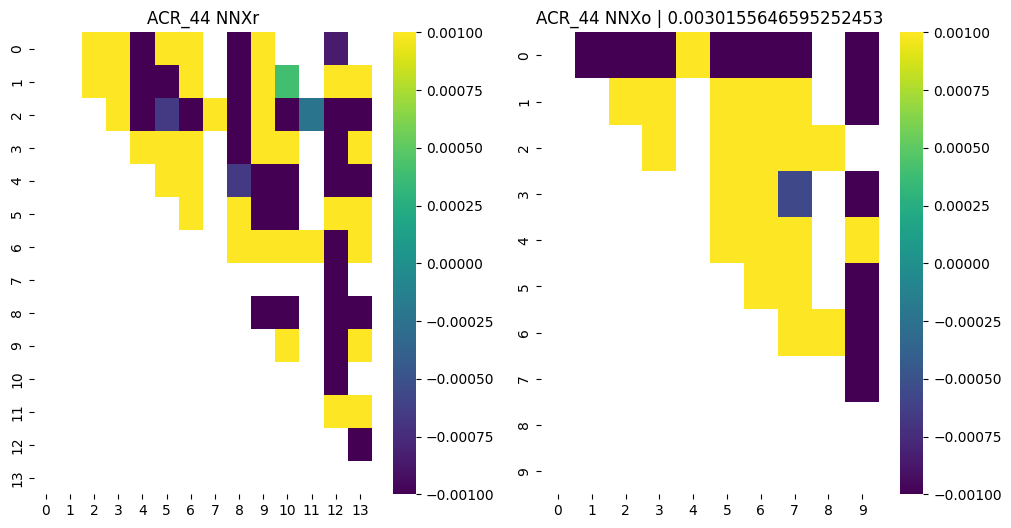

In [25]:
for subject in reb_rels_hom.keys():
    relrel = np.nanmean(reb_rels_hom[subject]['NNXo']) - np.nanmean(reb_rels_hom[subject]['NNXr'])
    f, ax = plt.subplots(1, 2, figsize=(12, 6))
    sns.heatmap(reb_rels_hom[subject]['NNXr'], cmap='viridis', vmin=-.001, vmax=.001, ax=ax[0])
    sns.heatmap(reb_rels_hom[subject]['NNXo'], cmap='viridis', vmin=-.001, vmax=.001, ax=ax[1])
    ax[0].set_title(f'{subject} NNXr')
    ax[1].set_title(f'{subject} NNXo | {relrel}')
    plt.show()

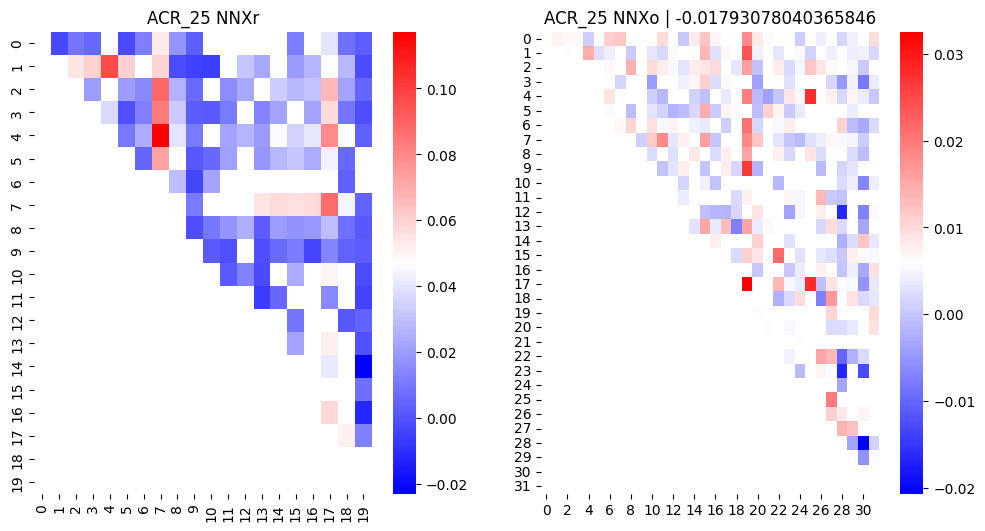

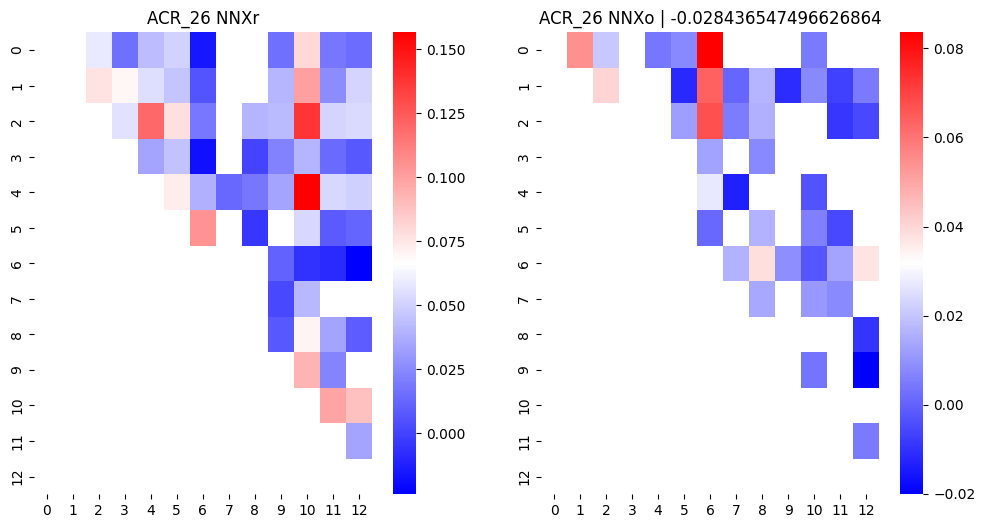

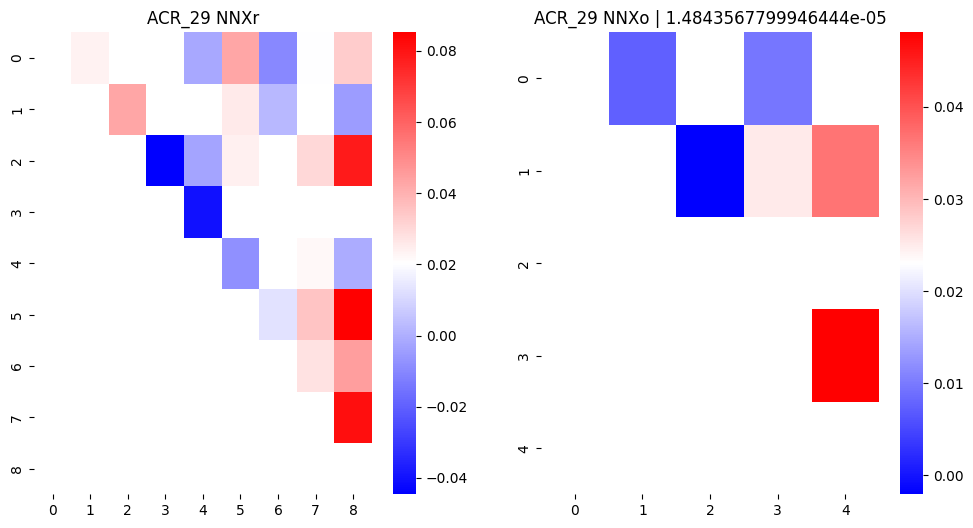

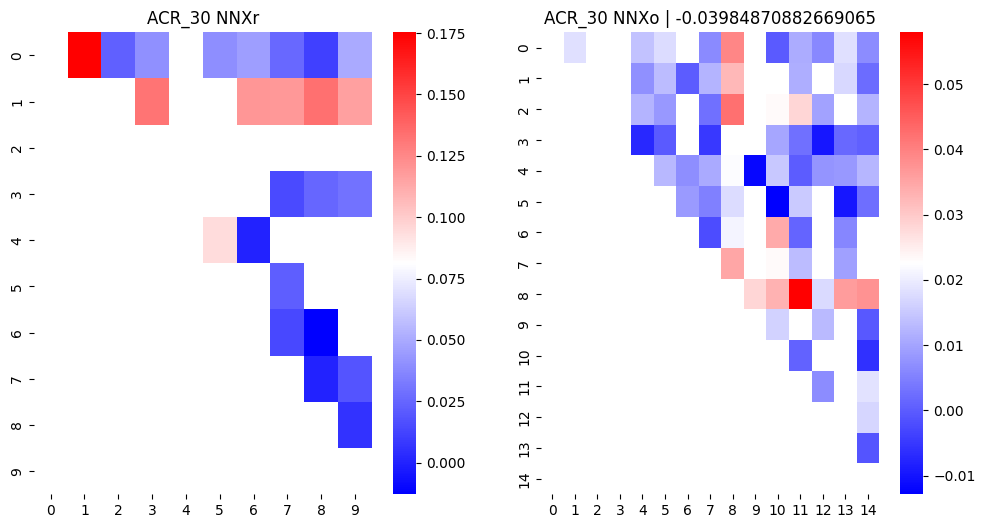

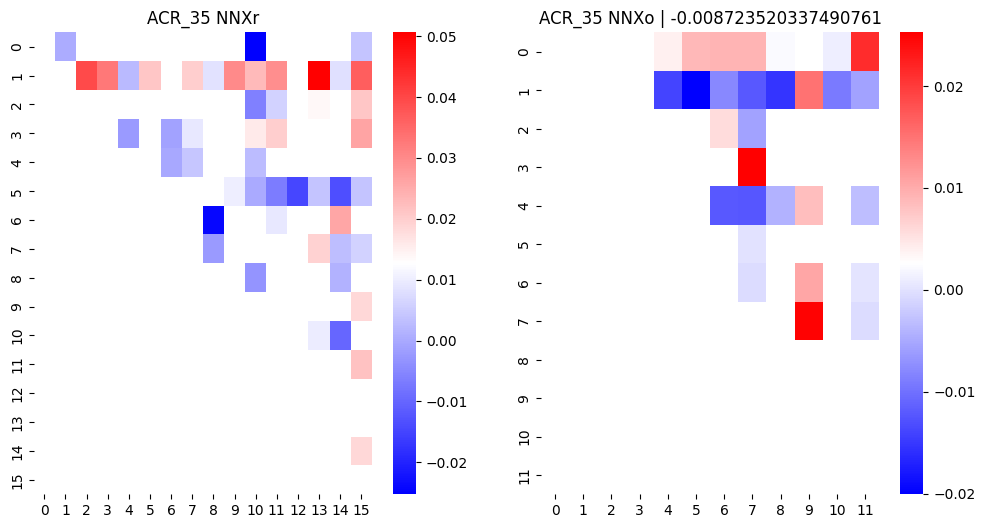

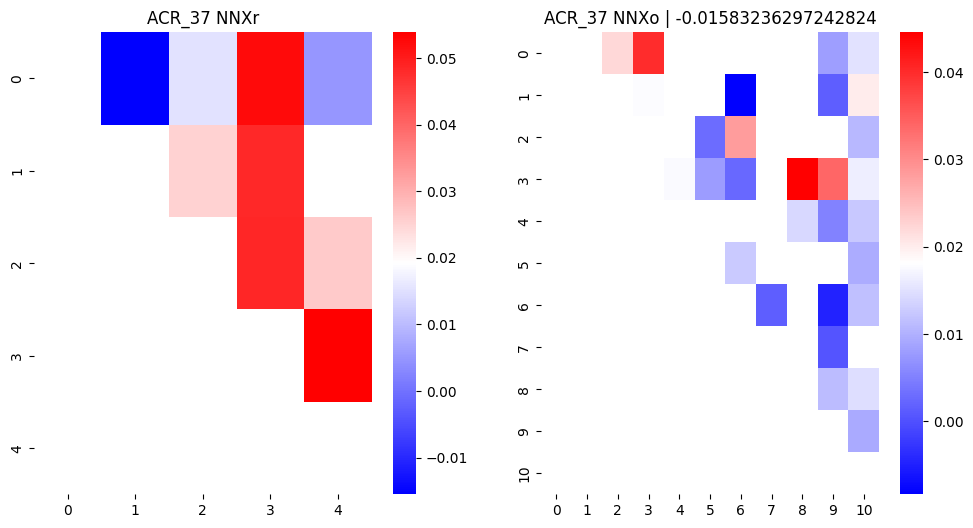

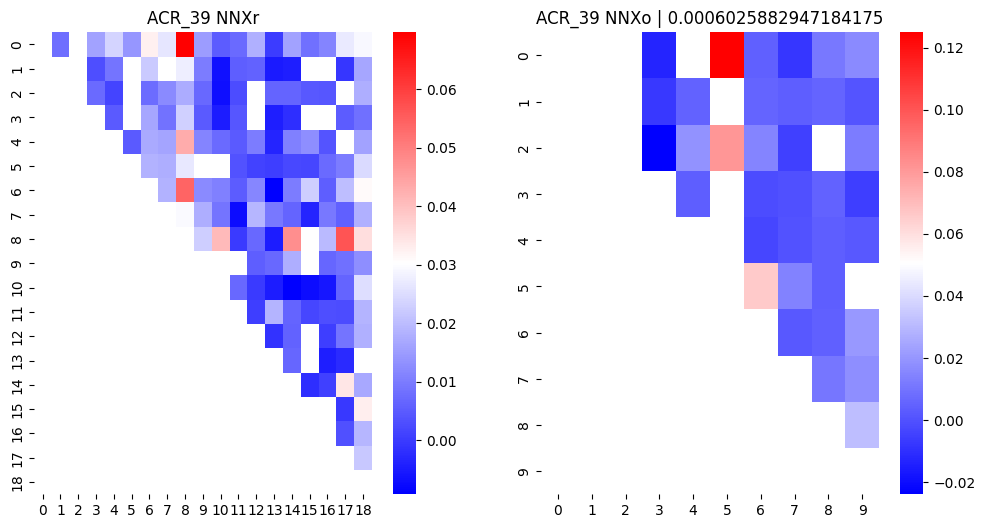

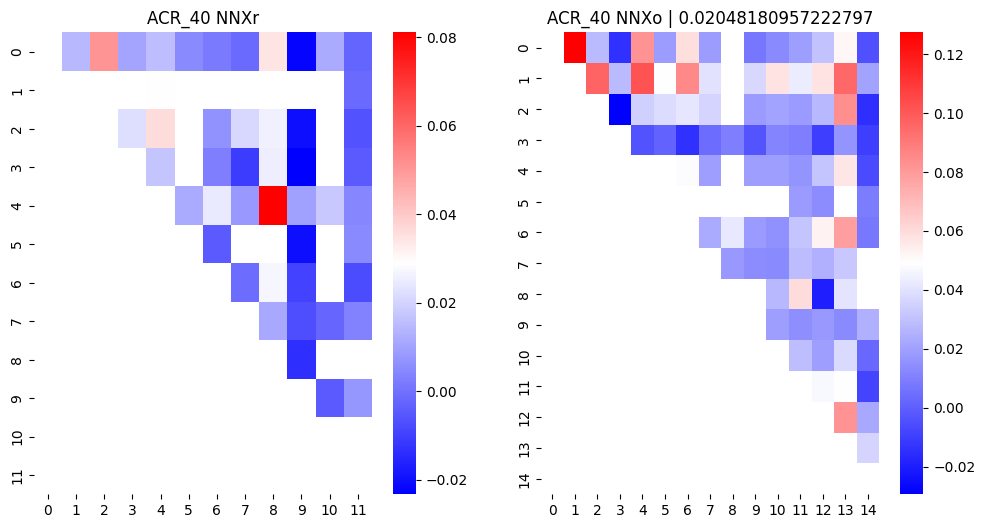

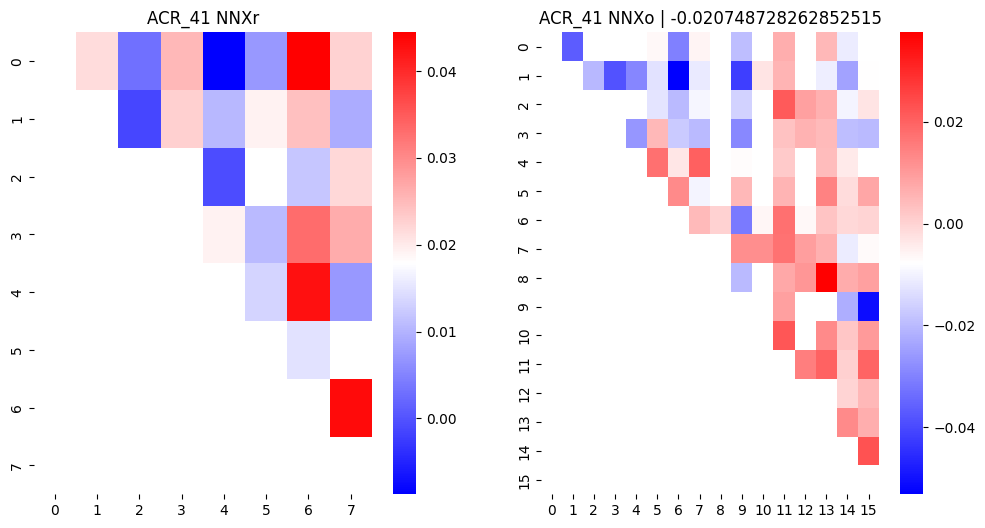

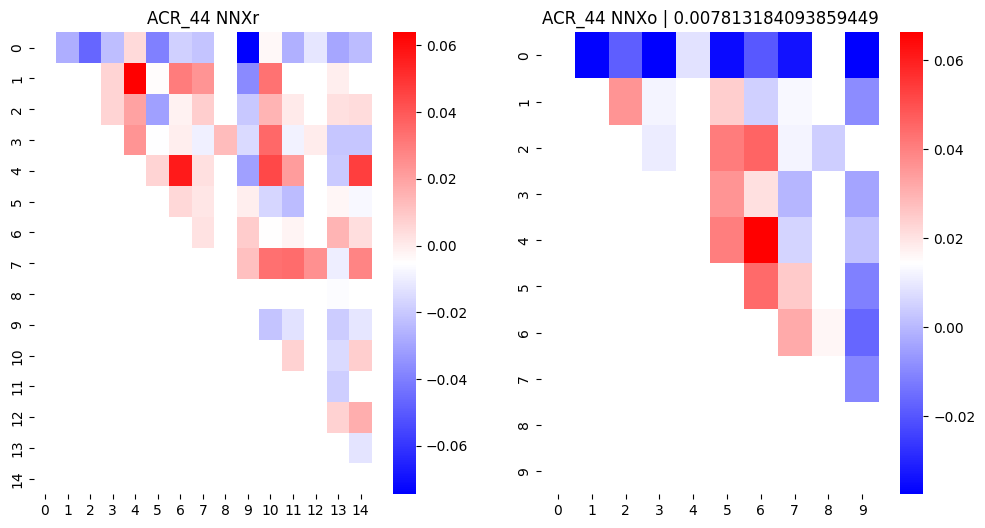

In [142]:
for subject in reb_rels_hom.keys():
    relrel = np.nanmean(reb_rels_hom[subject]['NNXo']) - np.nanmean(reb_rels_hom[subject]['NNXr'])
    f, ax = plt.subplots(1, 2, figsize=(12, 6))
    sns.heatmap(reb_rels_hom[subject]['NNXr'], cmap='bwr', ax=ax[0])
    sns.heatmap(reb_rels_hom[subject]['NNXo'], cmap='bwr', ax=ax[1])
    ax[0].set_title(f'{subject} NNXr')
    ax[1].set_title(f'{subject} NNXo | {relrel}')
    plt.show()

# Relative to global_mua - ON/OFF

In [ ]:
bindfs = [] 
oodfs = {}
for subject, exp in zip(subjects, exps):
        print(subject, exp)
        if subject in bindfs:
                oodf = load_bindf_with_hybrid_format(subject, exp)
        else:
                oodf = compute_hybrid_off_df(subject, exp, chan_threshold=12)
        oodf = acr.oo_utils.enhance_oodf(oodf, full_hyps[subject], hyp_dicts[subject])
        oodfs[subject] = oodf
full_oodf = pl.concat(oodfs.values())
off_means = full_oodf.group_by(['subject', 'probe', 'condition']).agg(pl.col('duration_rel').mean())

ACR_25 swi
ACR_26 swi
ACR_29 swi
ACR_30 swi2
ACR_35 swi
ACR_37 swi2
ACR_39 swi
ACR_40 swi
ACR_41 swi
ACR_44 swi


In [270]:
oowps = {}
for subject, exp in zip(subjects, exps):
        print(subject, exp)
        oodf = load_base_oodf(subject, exp)
        oodf = oodf.offs()
        oodf = acr.oo_utils.enhance_oodf(oodf, full_hyps[subject], hyp_dicts[subject])
        oowps[subject] = oodf
full_oodf = pl.concat(oowps.values())
off_means = full_oodf.group_by(['subject', 'probe', 'condition']).agg(pl.col('duration_rel').mean())

ACR_25 swi
ACR_26 swi
ACR_29 swi
ACR_30 swi2
ACR_35 swi
ACR_37 swi2
ACR_39 swi
ACR_40 swi
ACR_41 swi
ACR_44 swi


In [256]:
subject_dataframes = {}
for subject, exp in zip(subjects, exps):
    if subject == 'ACR_16':
        continue
    print(subject, exp)
    hd = hyp_dicts[subject]
    df_raw, qm, an = acr.ms.load_spike_df_with_qm(subject, exp, sorting_id, return_analyzers=True)
    # Filter at least on presence ratio
    unts = {}
    filt_dfs = []
    for probe in ['NNXo', 'NNXr']:
        qm_probe = qm.prb(probe)
        unts[probe] = acr.ms.select_good_units(qm_probe.to_pandas(), presence_min=0.8, full_mask=False)
        df_probe = df_raw.filter((pl.col('probe') == probe)&(pl.col('unit_id').is_in(unts[probe][0])))
        filt_dfs.append(df_probe)
    df = pl.concat(filt_dfs)
    circ_bl = hd['circ_bl']
    rebound = hd['rebound']
    circ_bl_rec, _t = acr.utils.get_rec_from_dt(subject, circ_bl['start_time'].iloc[0])
    rebound_rec, _t = acr.utils.get_rec_from_dt(subject, rebound['start_time'].iloc[0])
    subinf = acr.info_pipeline.subject_info_section(subject, 'rec_times')
    circ_bl_rec_start = pd.Timestamp(subinf[circ_bl_rec]['start'])
    rebound_rec_start = pd.Timestamp(subinf[rebound_rec]['start'])
    circ_bl_bout_starts = circ_bl['start_time']
    circ_bl_bout_ends = circ_bl['end_time']
    cbl_starts = np.array([(circ_bl_bout_starts[i] - circ_bl_rec_start).total_seconds() for i in range(len(circ_bl_bout_starts))])
    cbl_ends = np.array([(circ_bl_bout_ends[i] - circ_bl_rec_start).total_seconds() for i in range(len(circ_bl_bout_ends))])
    rebound_bout_starts = rebound['start_time']
    rebound_bout_ends = rebound['end_time']
    rb_starts = np.array([(rebound_bout_starts[i] - rebound_rec_start).total_seconds() for i in range(len(rebound_bout_starts))])
    rb_ends = np.array([(rebound_bout_ends[i] - rebound_rec_start).total_seconds() for i in range(len(rebound_bout_ends))])
    epocs_final = {}
    

    cbl_durs = cbl_ends-cbl_starts
    borders = [0]
    for i in range(len(cbl_durs)):
        borders.append(borders[-1]+cbl_durs[i])
    epocs_final['circ-bl'] = []
    for i in range(len(borders)-1):
        epocs_final['circ-bl'].append((borders[i], borders[i+1]))

    rb_durs = rb_ends-rb_starts
    borders = [0]
    for i in range(len(rb_durs)):
        borders.append(borders[-1]+rb_durs[i])
    epocs_final['rebound'] = []
    for i in range(len(borders)-1):
        epocs_final['rebound'].append((borders[i], borders[i+1]))
    reb_df = df.cdn('rebound').sort('time')
    circ_df = df.cdn('circ-bl').sort('time')
    circ_bl_times = circ_df['time'].to_numpy()
    reb_times = reb_df['time'].to_numpy()
    reb_times = reb_times - 3600
    # get the datetime index to reb_df
    indices = [np.searchsorted(reb_times, epocs_final['rebound'][i][1]) for i in range(len(epocs_final['rebound']))]
    current = 0
    epoc_arrays = []
    for i, ix in enumerate(indices):
        epoc_array = reb_times[current:ix]
        epoc_array_rel = epoc_array - epocs_final['rebound'][i][0]
        epoc_arrays.append(epoc_array_rel)
        current = ix
    dt_arrs = []
    epoc_starts = hd['rebound']['start_time']
    for arr, start in zip(epoc_arrays, epoc_starts):
        td_arr = pd.to_timedelta(arr, unit='s')
        dt_arr = start + td_arr
        dt_arrs.append(dt_arr)
    full_dt = np.concat(dt_arrs)
    reb_df = reb_df.with_columns(pl.lit(full_dt).alias('datetime'))
    # get the datetime index to circ_df
    indices = [np.searchsorted(circ_bl_times, epocs_final['circ-bl'][i][1]) for i in range(len(epocs_final['circ-bl']))]
    current = 0
    epoc_arrays = []
    for i, ix in enumerate(indices):
        epoc_array = circ_bl_times[current:ix]
        epoc_array_rel = epoc_array - epocs_final['circ-bl'][i][0]
        epoc_arrays.append(epoc_array_rel)
        current = ix
    dt_arrs = []
    epoc_starts = hd['circ_bl']['start_time']
    for arr, start in zip(epoc_arrays, epoc_starts):
        td_arr = pd.to_timedelta(arr, unit='s')
        dt_arr = start + td_arr
        dt_arrs.append(dt_arr)
    full_dt = np.concat(dt_arrs)
    circ_df = circ_df.with_columns(pl.lit(full_dt).alias('datetime'))
    subject_dataframes[subject] = pl.concat([circ_df, reb_df])

ACR_25 swi
ACR_26 swi
ACR_29 swi
ACR_30 swi2
ACR_35 swi
ACR_37 swi2
ACR_39 swi
ACR_40 swi
ACR_41 swi
ACR_44 swi


In [274]:
final_distances = {}
conds = ['circ-bl', 'rebound']
probes = ['NNXo', 'NNXr']
for subject in subjects:
    final_distances[subject] = {}
    for cond in conds:
        if cond == 'circ-bl':
            old_cond = 'circ_bl'
        else:
            old_cond = 'rebound'
        final_distances[subject][cond] = {}
        for probe in probes:
            odf = oodfs[subject].prb(probe).cdn(old_cond)
            starts = odf['start_datetime'].to_numpy()
            ends = odf['end_datetime'].to_numpy()
            prb_df = subject_dataframes[subject].filter(pl.col('probe') == probe).cdn(cond).sort('datetime')
            unit_ids = prb_df['unit_id'].unique().to_numpy()
            unit_ids = np.sort(unit_ids)
            spike_trains = {}
            for unit_id in unit_ids:
                spike_trains[unit_id] = prb_df.filter(pl.col('unit_id') == unit_id)['datetime'].to_numpy()
            spkdistances = {}
            for uid in unit_ids:
                start_inserts = np.searchsorted(spike_trains[uid], starts, side='left')
                nearest_spikes = spike_trains[uid][start_inserts-1]
                spike_distances = starts - nearest_spikes
                spike_distances = spike_distances[spike_distances > np.timedelta64(0, 's')]
                spkdistances[uid] = spike_distances/np.timedelta64(1, 's')
            final_distances[subject][cond][probe] = spkdistances

In [ ]:
for subject in subjects:
    f, ax = plt.subplots(1, 2, figsize=(16, 8))
    circ_distances = [np.mean(final_distances[subject]['circ-bl']['NNXr'][uid]) for uid in final_distances[subject]['circ-bl']['NNXr'].keys()]
    reb_distances = [np.mean(final_distances[subject]['rebound']['NNXr'][uid]) for uid in final_distances[subject]['rebound']['NNXr'].keys()]
    acr.plots.gen_paired_boxplot(circ_distances, reb_distances, colors=[NNXR_GRAY, 'teal'], ax=ax[0])
    
    circ_distances = [np.mean(final_distances[subject]['circ-bl']['NNXo'][uid]) for uid in final_distances[subject]['circ-bl']['NNXo'].keys()]
    reb_distances = [np.mean(final_distances[subject]['rebound']['NNXo'][uid]) for uid in final_distances[subject]['rebound']['NNXo'].keys()]
    acr.plots.gen_paired_boxplot(circ_distances, reb_distances, ax=ax[1])
    f.suptitle(subject)

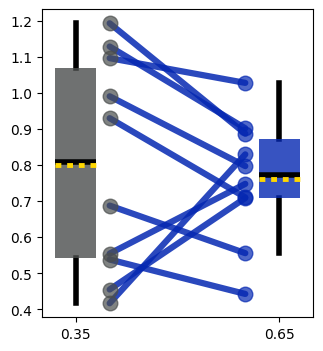

In [273]:
r_means = []
o_means = []
for subject in subjects:
    circ_distances = [np.mean(final_distances[subject]['circ-bl']['NNXr'][uid]) for uid in final_distances[subject]['circ-bl']['NNXr'].keys()]
    reb_distances = [np.mean(final_distances[subject]['rebound']['NNXr'][uid]) for uid in final_distances[subject]['rebound']['NNXr'].keys()]
    r_means.append(np.mean(reb_distances)/np.mean(circ_distances))
    circ_distances = [np.mean(final_distances[subject]['circ-bl']['NNXo'][uid]) for uid in final_distances[subject]['circ-bl']['NNXo'].keys()]
    reb_distances = [np.mean(final_distances[subject]['rebound']['NNXo'][uid]) for uid in final_distances[subject]['rebound']['NNXo'].keys()]
    o_means.append(np.mean(reb_distances)/np.mean(circ_distances))

r_means = np.array(r_means)
o_means = np.array(o_means)
mask = r_means < 20
f, ax = acr.plots.gen_paired_boxplot(r_means[mask], o_means[mask], colors=[NNXR_GRAY, MAIN_COLOR])

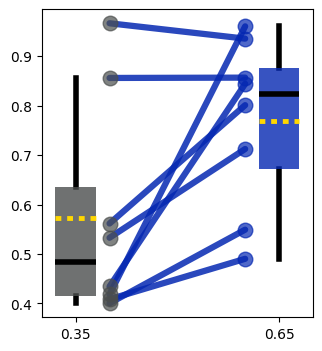

In [276]:
r_means = []
o_means = []
for subject in subjects:
    circ_distances = [np.mean(final_distances[subject]['circ-bl']['NNXr'][uid]) for uid in final_distances[subject]['circ-bl']['NNXr'].keys()]
    reb_distances = [np.mean(final_distances[subject]['rebound']['NNXr'][uid]) for uid in final_distances[subject]['rebound']['NNXr'].keys()]
    r_means.append(np.mean(reb_distances)/np.mean(circ_distances))
    circ_distances = [np.mean(final_distances[subject]['circ-bl']['NNXo'][uid]) for uid in final_distances[subject]['circ-bl']['NNXo'].keys()]
    reb_distances = [np.mean(final_distances[subject]['rebound']['NNXo'][uid]) for uid in final_distances[subject]['rebound']['NNXo'].keys()]
    o_means.append(np.mean(reb_distances)/np.mean(circ_distances))

r_means = np.array(r_means)
o_means = np.array(o_means)
mask = r_means < 1
f, ax = acr.plots.gen_paired_boxplot(r_means[mask], o_means[mask], colors=[NNXR_GRAY, MAIN_COLOR])

In [277]:
pg.ttest(r_means[mask], o_means[mask], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.81487,7,two-sided,0.025964,"[-0.36, -0.03]",0.995697,3.116,0.677155


In [282]:
final_distances = {}
conds = ['circ-bl', 'rebound']
probes = ['NNXo', 'NNXr']
for subject in subjects:
    final_distances[subject] = {}
    for cond in conds:
        if cond == 'circ-bl':
            old_cond = 'circ_bl'
        else:
            old_cond = 'rebound'
        final_distances[subject][cond] = {}
        for probe in probes:
            odf = oodfs[subject].prb(probe).cdn(old_cond)
            starts = odf['start_datetime'].to_numpy()
            ends = odf['end_datetime'].to_numpy()
            prb_df = subject_dataframes[subject].filter(pl.col('probe') == probe).cdn(cond).sort('datetime')
            unit_ids = prb_df['unit_id'].unique().to_numpy()
            unit_ids = np.sort(unit_ids)
            spike_trains = {}
            for unit_id in unit_ids:
                spike_trains[unit_id] = prb_df.filter(pl.col('unit_id') == unit_id)['datetime'].to_numpy()
            spkdistances = {}
            for uid in unit_ids:
                end_inserts = np.searchsorted(spike_trains[uid], ends, side='right')
                end_inserts = np.clip(end_inserts, 0, len(spike_trains[uid])-2)
                nearest_spikes = spike_trains[uid][end_inserts+1]
                spike_distances = nearest_spikes - ends
                spike_distances = spike_distances[spike_distances > np.timedelta64(0, 's')]
                spkdistances[uid] = spike_distances/np.timedelta64(1, 's')
            final_distances[subject][cond][probe] = spkdistances

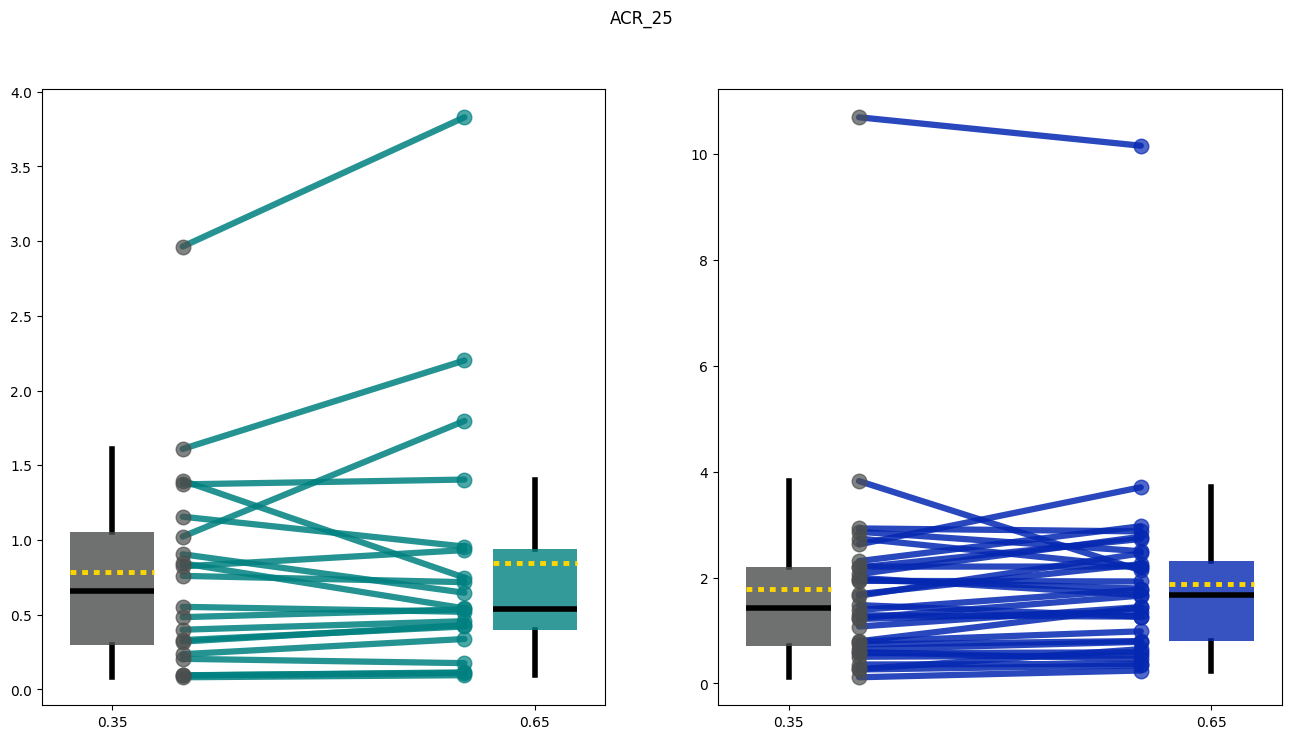

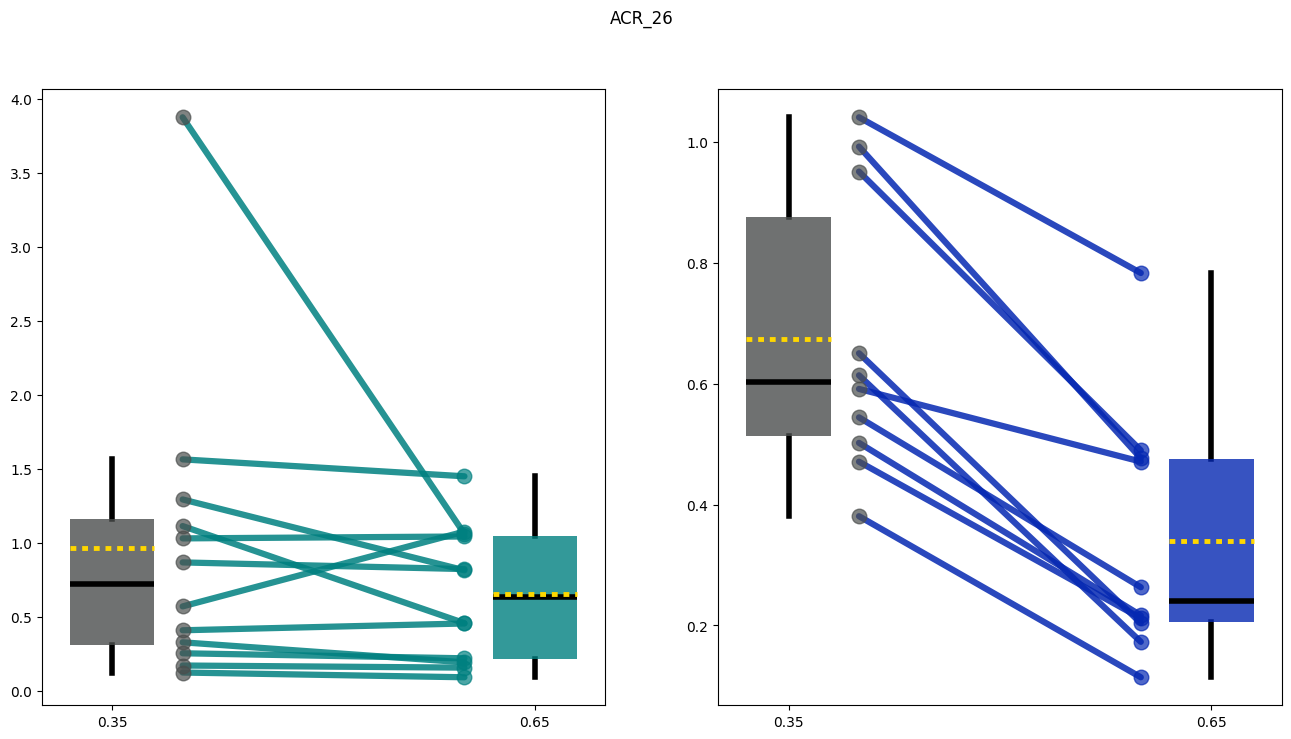

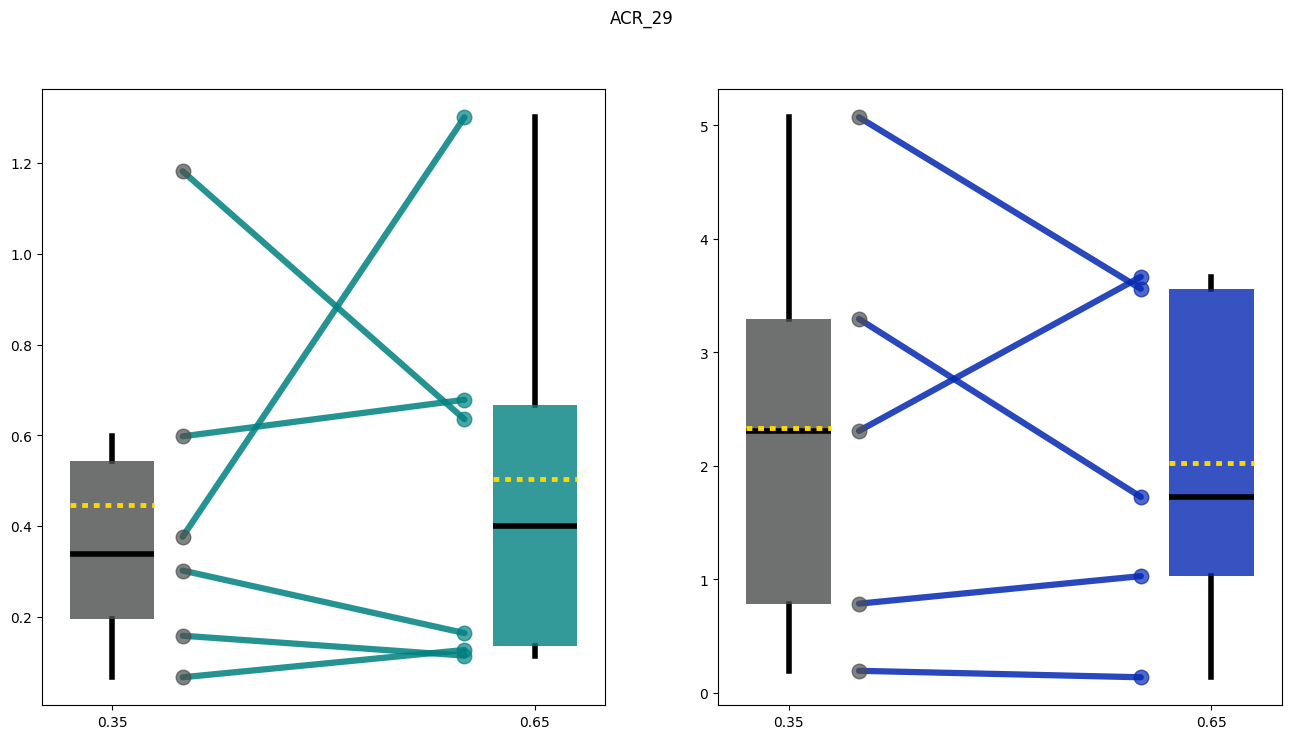

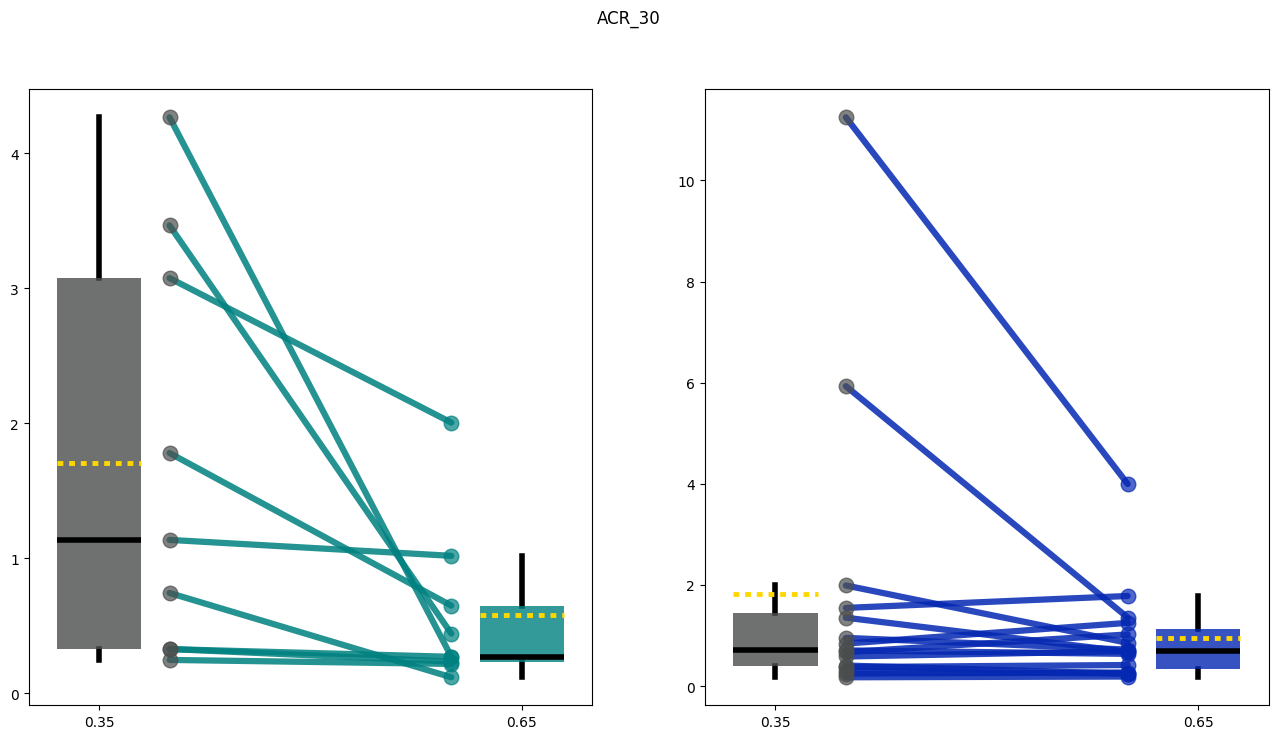

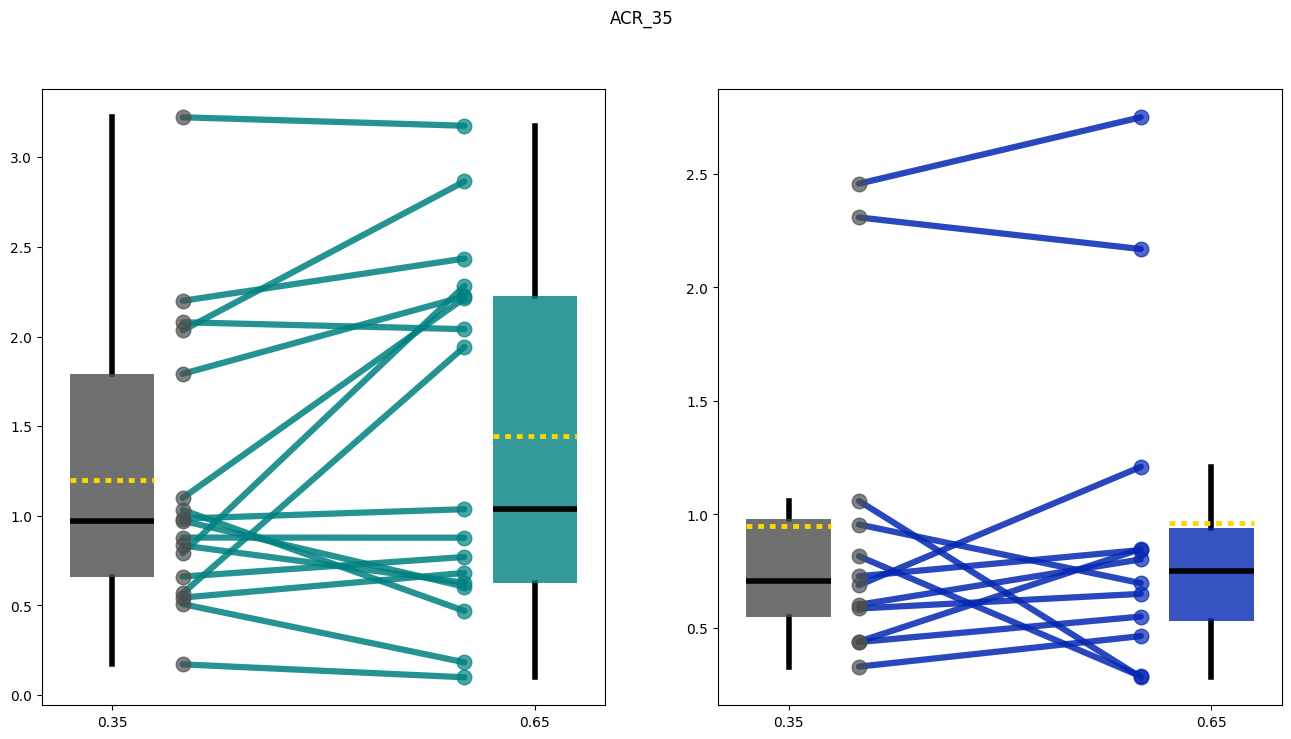

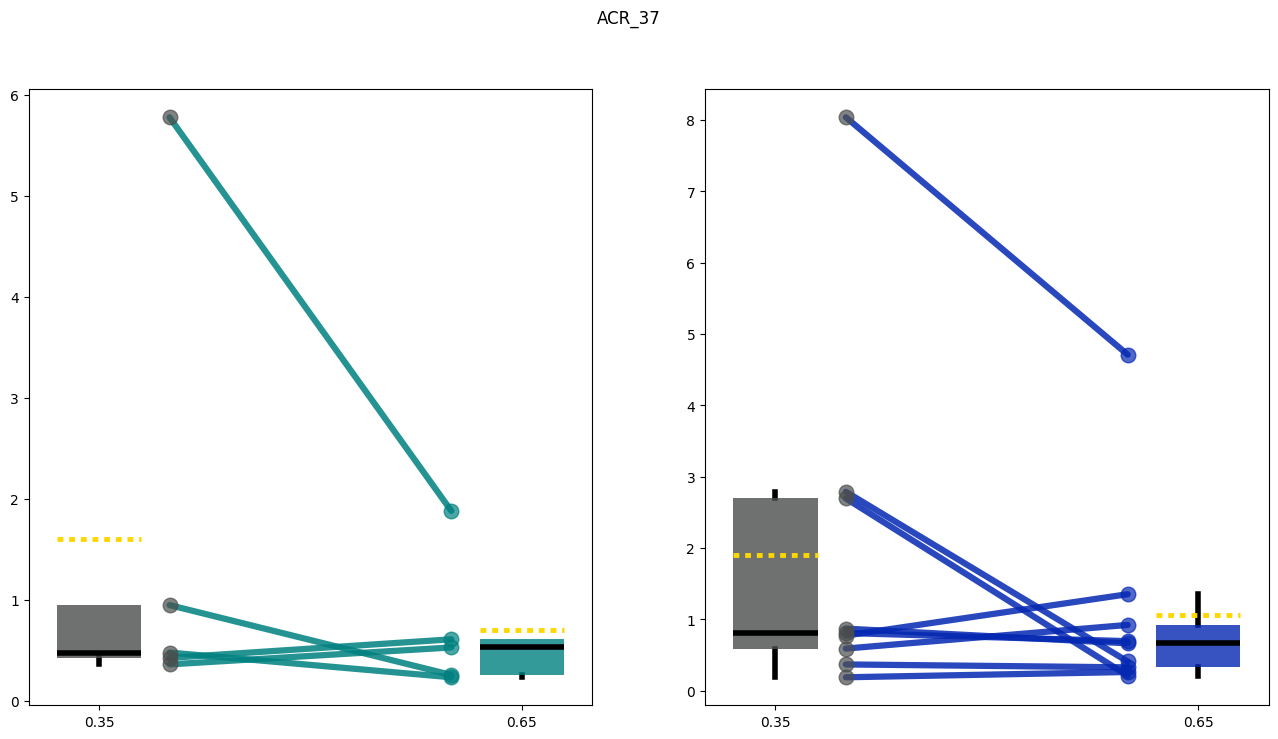

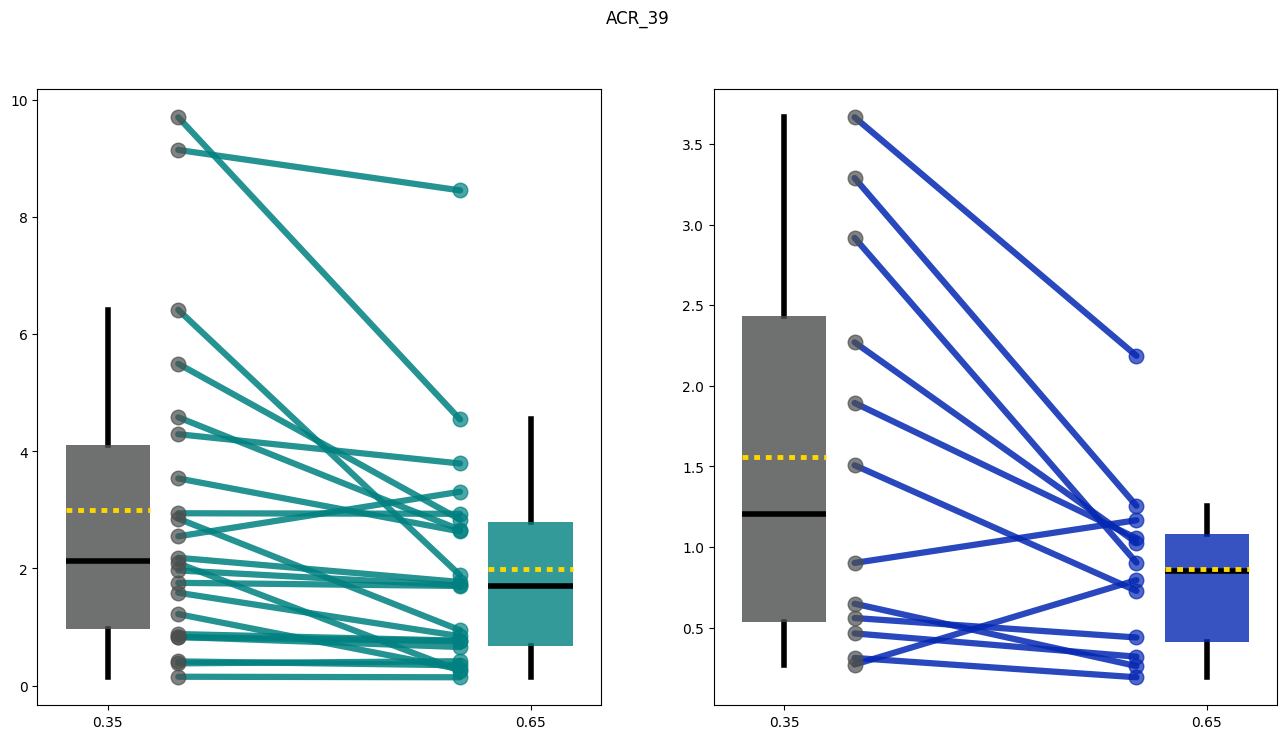

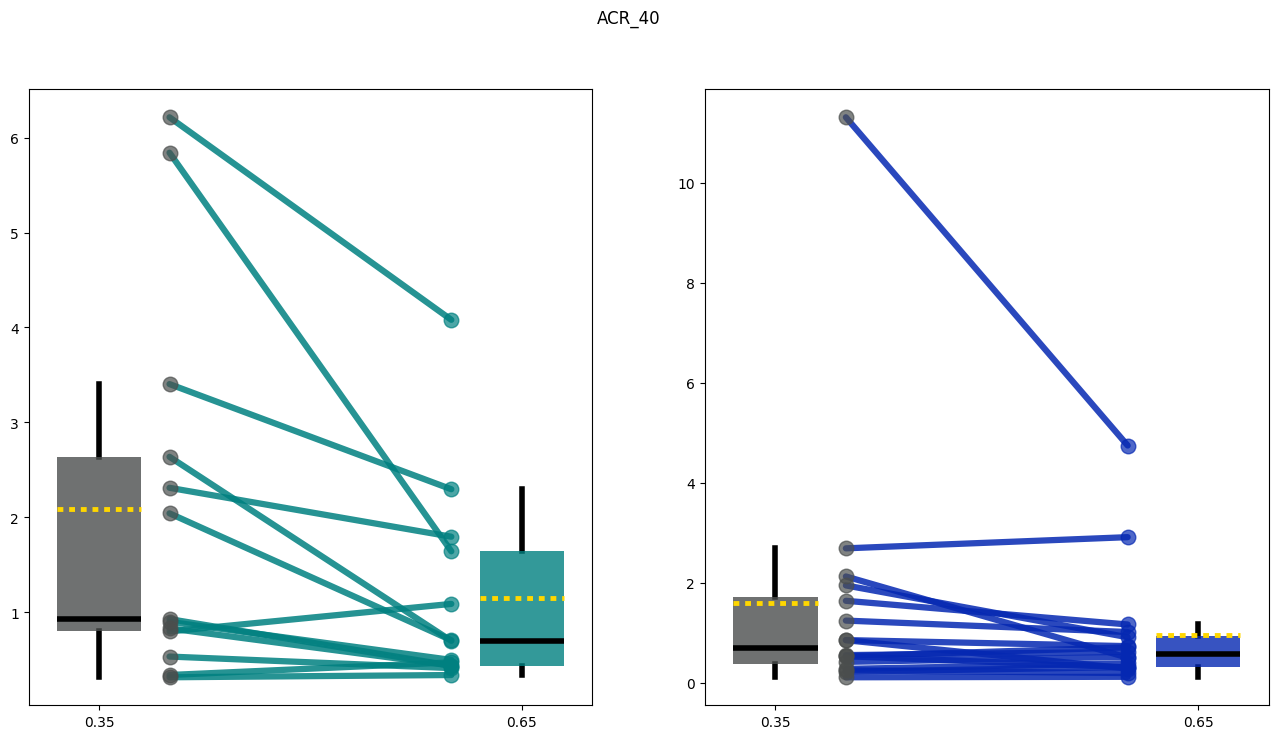

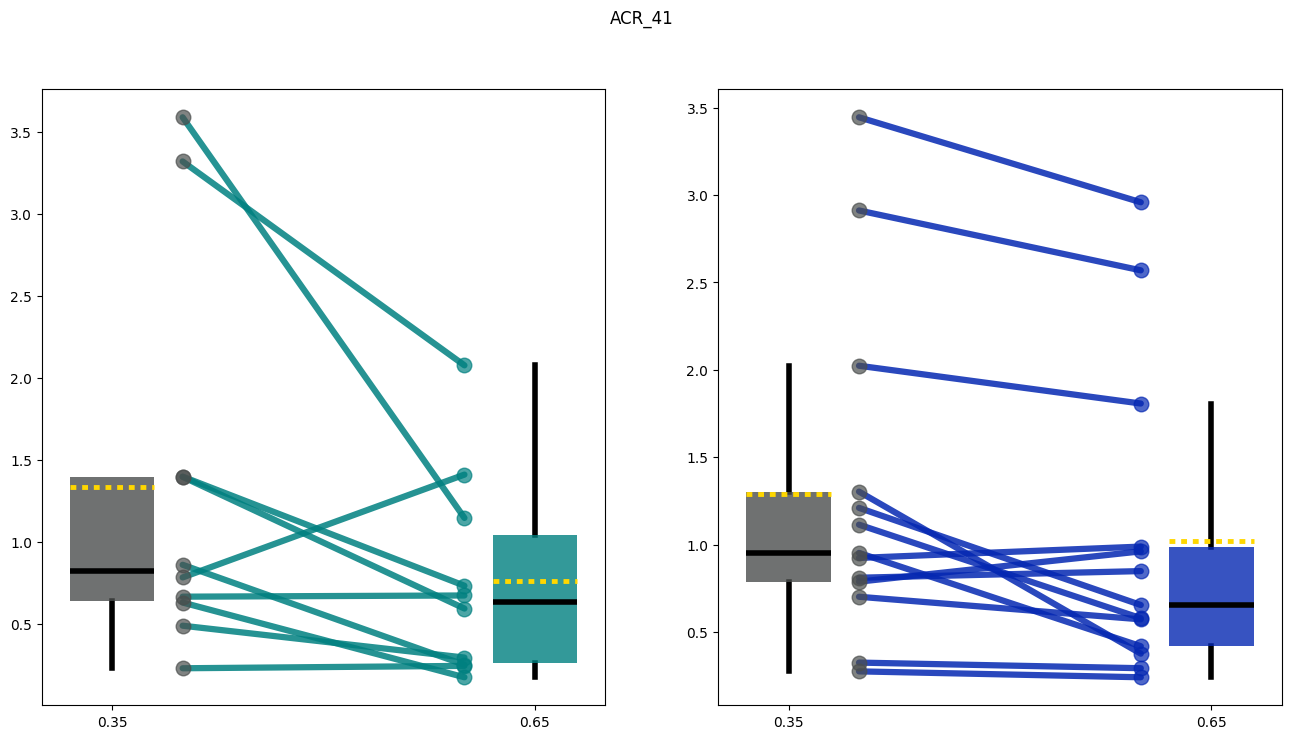

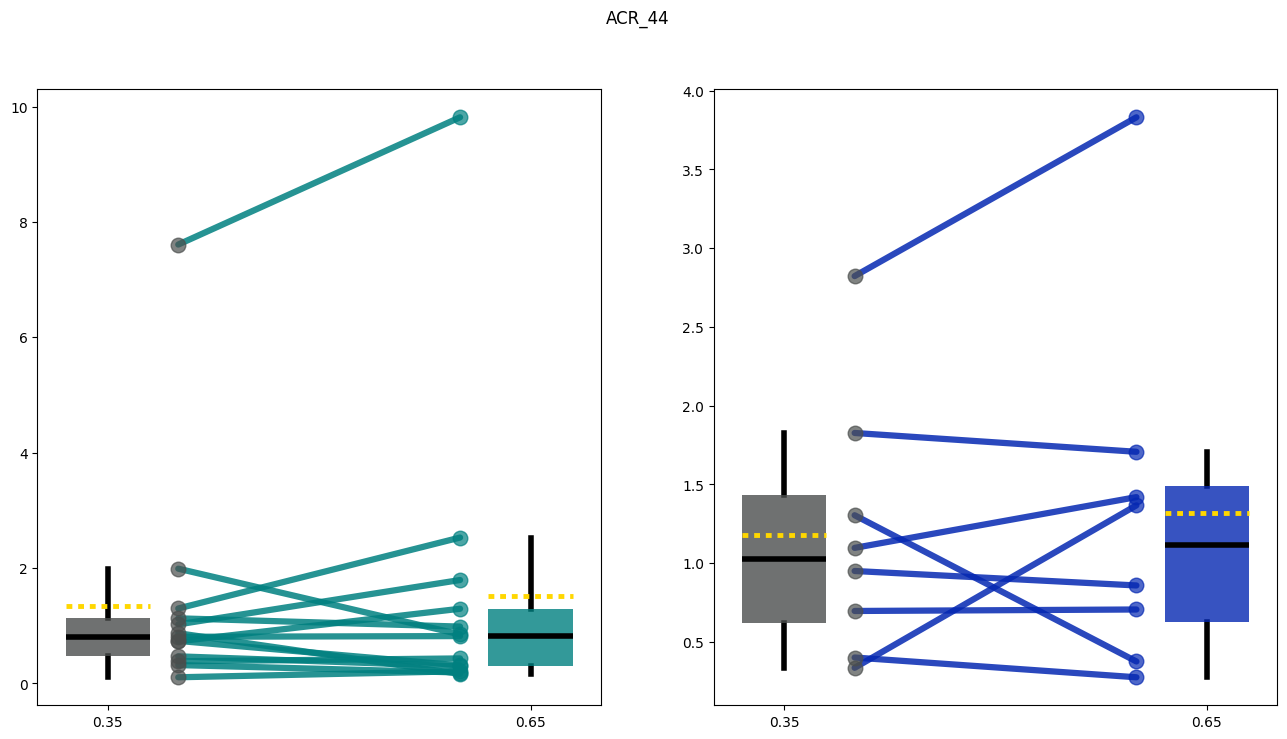

In [283]:
for subject in subjects:
    f, ax = plt.subplots(1, 2, figsize=(16, 8))
    circ_distances = [np.mean(final_distances[subject]['circ-bl']['NNXr'][uid]) for uid in final_distances[subject]['circ-bl']['NNXr'].keys()]
    reb_distances = [np.mean(final_distances[subject]['rebound']['NNXr'][uid]) for uid in final_distances[subject]['rebound']['NNXr'].keys()]
    acr.plots.gen_paired_boxplot(circ_distances, reb_distances, colors=[NNXR_GRAY, 'teal'], ax=ax[0])
    
    circ_distances = [np.mean(final_distances[subject]['circ-bl']['NNXo'][uid]) for uid in final_distances[subject]['circ-bl']['NNXo'].keys()]
    reb_distances = [np.mean(final_distances[subject]['rebound']['NNXo'][uid]) for uid in final_distances[subject]['rebound']['NNXo'].keys()]
    acr.plots.gen_paired_boxplot(circ_distances, reb_distances, ax=ax[1])
    f.suptitle(subject)

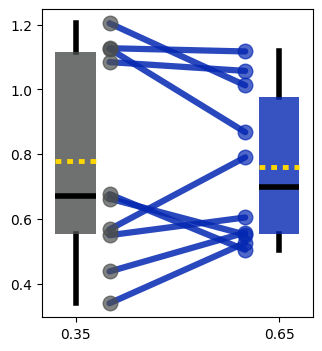

In [285]:
r_means = []
o_means = []
for subject in subjects:
    circ_distances = [np.mean(final_distances[subject]['circ-bl']['NNXr'][uid]) for uid in final_distances[subject]['circ-bl']['NNXr'].keys()]
    reb_distances = [np.mean(final_distances[subject]['rebound']['NNXr'][uid]) for uid in final_distances[subject]['rebound']['NNXr'].keys()]
    r_means.append(np.mean(reb_distances)/np.mean(circ_distances))
    circ_distances = [np.mean(final_distances[subject]['circ-bl']['NNXo'][uid]) for uid in final_distances[subject]['circ-bl']['NNXo'].keys()]
    reb_distances = [np.mean(final_distances[subject]['rebound']['NNXo'][uid]) for uid in final_distances[subject]['rebound']['NNXo'].keys()]
    o_means.append(np.mean(reb_distances)/np.mean(circ_distances))

r_means = np.array(r_means)
o_means = np.array(o_means)
mask = r_means < 10
f, ax = acr.plots.gen_paired_boxplot(r_means[mask], o_means[mask], colors=[NNXR_GRAY, MAIN_COLOR])

In [281]:
pg.ttest(r_means[mask], o_means[mask], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.792282,6,two-sided,0.123263,"[-0.28, 0.04]",0.614951,1.036,0.279174


# Excit_only

In [75]:
for sub in df_filts.keys():
    print(len(df_filts[sub]))

3612906
3335191
1324055
2169970
2084751
1500957
1842070
2641886
1760910
2374430


In [91]:
df_filts = {}
ans = {}
qms = {}
for subject, exp in zip(subjects, exps):
    print(subject, exp)
    df_raw, qm, an = acr.ms.load_spike_df_with_qm(subject, exp, sorting_id, return_analyzers=True)
    unts = {}
    filt_dfs = []
    qms[subject] = qm
    for probe in ['NNXo', 'NNXr']:
        qm_probe = qm.prb(probe)        
        unts[probe] = acr.ms.select_good_units(qm_probe.to_pandas(), presence_min=0.95, full_mask=False)
        untsin = unts[probe][0]
        if subject in uidxs.keys():
            if probe in uidxs[subject].keys():
                mask = np.isin(untsin, uidxs[subject][probe])
                untsin = untsin[~mask]
        df_probe = df_raw.filter((pl.col('probe') == probe)&(pl.col('unit_id').is_in(untsin)))
        filt_dfs.append(df_probe)
    qms[subject] = qms[subject].with_columns(pl.lit(subject).alias('subject'))
    df = pl.concat(filt_dfs)
    rt_sub = rate_types.filter(pl.col('subject')==subject)
    df = df.with_columns(pl.lit(subject).alias('subject'))
    df = df.join(rt_sub, on=['subject', 'probe', 'unit_id'], how='left')
    df = df.filter(pl.col('cell_type')=='pyr')
    df_filts[subject] = df
    
    ans[subject] = an

ACR_25 swi
ACR_26 swi
ACR_29 swi
ACR_30 swi2
ACR_35 swi
ACR_37 swi2
ACR_39 swi
ACR_40 swi
ACR_41 swi
ACR_44 swi


In [92]:
for sub in df_filts.keys():
    print(len(df_filts[sub]))

2425243
2203967
839110
2169970
1652788
1235051
1575843
2101746
1539108
1991592


In [93]:
df_counts = []
for subject in df_filts.keys():
    dc = df_filts[subject].group_by('probe').agg(pl.col('unit_id').unique().count())
    dc = dc.to_pandas()
    dc['subject'] = subject
    dc['sub_type'] = SUBJECT_TYPE
    df_counts.append(dc)
df_count = pd.concat(df_counts)
df_count.to_parquet(f'{SUBJECT_TYPE}_dfcounts_excit.parquet')

In [94]:
cond_dfs = {}
spike_trains = {}
sttcs = {}
for subject in df_filts.keys():
    cond_dfs[subject] = {}
    times = [
        (0, 3600),
        (3600, 7200),
        (7200, 10800)
    ]
    for tt, cond in zip(times, ['early_bl', 'circ_bl', 'rebound']):
        cond_df = df_filts[subject].filter((pl.col('time')>=tt[0])&(pl.col('time')<tt[1]))
        dftimes = cond_df['time'].to_numpy()
        times_rel = dftimes - tt[0]
        cond_df = cond_df.with_columns(pl.lit(times_rel).alias('time_rel'))
        cond_dfs[subject][cond] = cond_df
for subject in df_filts.keys():
    spike_trains[subject] = {}
    for cond in cond_dfs[subject]:
        spike_trains[subject][cond] = {}
        for probe in ['NNXo', 'NNXr']:
            spike_trains[subject][cond][probe] = []
            uids = cond_dfs[subject][cond].prb(probe)['unit_id'].unique().to_numpy()
            uids = np.sort(uids)
            for uid in uids:
                spike_trains[subject][cond][probe].append(cond_dfs[subject][cond].prb(probe).filter(pl.col('unit_id') == uid)['time_rel'].to_numpy())
for subject in spike_trains.keys():
    sttcs[subject] = {}
    for cond in spike_trains[subject].keys():
        sttcs[subject][cond] = {}
        for probe in spike_trains[subject][cond].keys():
            sttcs[subject][cond][probe] = acr.sync.sttc_matrix_fast(spike_trains[subject][cond][probe], 0, 3600, .005)

# Subject - Level STTC

In [95]:
reb_rels_hom = {}
for subject in spike_trains.keys():
    reb_rels_hom[subject] = {}
    for probe in ['NNXr', 'NNXo']:
        hom = sttcs[subject]['early_bl'][probe] - sttcs[subject]['circ_bl'][probe]
        mask = hom > 0.0
        # where mask is false, set hom to nan
        hom[~mask] = np.nan
        
        eps = 1e-6
        cbl_mtx = np.arctanh(np.clip(sttcs[subject]['circ_bl'][probe], -1+eps, 1-eps))
        reb_mtx = np.arctanh(np.clip(sttcs[subject]['rebound'][probe], -1+eps, 1-eps))
        
        reb_rel = reb_mtx - cbl_mtx
        reb_rel[~mask] = np.nan
        reb_rels_hom[subject][probe] = reb_rel
nnxo = np.array([np.nanmean(reb_rels_hom[subject]['NNXo']) for subject in reb_rels_hom.keys()])
nnxr = np.array([np.nanmean(reb_rels_hom[subject]['NNXr']) for subject in reb_rels_hom.keys()])

In [96]:
reb_rels_fixed = {}
for subject in spike_trains.keys():
    reb_rels_fixed[subject] = {}
    for probe in ['NNXr', 'NNXo']:
        hom = sttcs[subject]['early_bl'][probe] - sttcs[subject]['circ_bl'][probe]
        mask = hom <= 0.0
        # where mask is false, set hom to nan
        hom[~mask] = np.nan
        
        eps = 1e-6
        cbl_mtx = np.arctanh(np.clip(sttcs[subject]['circ_bl'][probe], -1+eps, 1-eps))
        reb_mtx = np.arctanh(np.clip(sttcs[subject]['rebound'][probe], -1+eps, 1-eps))
        
        reb_rel = reb_mtx - cbl_mtx
        reb_rel[~mask] = np.nan
        reb_rels_fixed[subject][probe] = reb_rel
nnxo = np.array([np.nanmean(reb_rels_fixed[subject]['NNXo']) for subject in reb_rels_fixed.keys()])
nnxr = np.array([np.nanmean(reb_rels_fixed[subject]['NNXr']) for subject in reb_rels_fixed.keys()])

# Single Unit-Level STTC

In [97]:
cond_dfs = {}
spike_trains = {}
sttcs = {}
for subject in df_filts.keys():
    cond_dfs[subject] = {}
    times = [
        (0, 3600),
        (3600, 7200),
        (7200, 10800)
    ]
    for tt, cond in zip(times, ['early_bl', 'circ_bl', 'rebound']):
        cond_df = df_filts[subject].filter((pl.col('time')>=tt[0])&(pl.col('time')<tt[1]))
        dftimes = cond_df['time'].to_numpy()
        times_rel = dftimes - tt[0]
        cond_df = cond_df.with_columns(pl.lit(times_rel).alias('time_rel'))
        cond_dfs[subject][cond] = cond_df
for subject in df_filts.keys():
    spike_trains[subject] = {}
    for cond in cond_dfs[subject]:
        spike_trains[subject][cond] = {}
        for probe in ['NNXo', 'NNXr']:
            spike_trains[subject][cond][probe] = []
            uids = cond_dfs[subject][cond].prb(probe)['unit_id'].unique().to_numpy()
            uids = np.sort(uids)
            for uid in uids:
                spike_trains[subject][cond][probe].append(cond_dfs[subject][cond].prb(probe).filter(pl.col('unit_id') == uid)['time_rel'].to_numpy())
for subject in spike_trains.keys():
    sttcs[subject] = {}
    for cond in spike_trains[subject].keys():
        sttcs[subject][cond] = {}
        for probe in spike_trains[subject][cond].keys():
            sttcs[subject][cond][probe] = acr.sync.sttc_matrix_fast(spike_trains[subject][cond][probe], 0, 3600, .005)

In [98]:
# Homeostatically regulated unit pairs
ubu_hom = {}
ubudf_hom = {}
ubudf_hom['NNXo'] = []
ubudf_hom['NNXr'] = []
for subject in spike_trains.keys():
    ubu_hom[subject] = {}
    for probe in ['NNXo', 'NNXr']:
        hom = sttcs[subject]['early_bl'][probe] - sttcs[subject]['circ_bl'][probe]
        mask = hom > 0.0
        ebl = sttcs[subject]['early_bl'][probe]
        cbl = sttcs[subject]['circ_bl'][probe]
        reb = sttcs[subject]['rebound'][probe]
        ebl[~mask] = np.nan
        cbl[~mask] = np.nan
        reb[~mask] = np.nan
        cbl_df = acr.stats.get_positions_and_values_df(cbl, 'sttc_late', subject)
        reb_df = acr.stats.get_positions_and_values_df(reb, 'sttc_rebound', subject)
        reb_df = reb_df.merge(cbl_df, on=['mouse', 'unit_i', 'unit_j'], how='inner')
        reb_df['probe'] = probe
        ubudf_hom[probe].append(reb_df)
ubudf_hom['NNXo'] = pd.concat(ubudf_hom['NNXo'])
ubudf_hom['NNXr'] = pd.concat(ubudf_hom['NNXr'])
main_ubudf_hom = pd.concat(ubudf_hom.values())
main_ubudf_hom['probe'] = main_ubudf_hom['probe'].replace({'NNXo': 'optrode', 'NNXr': 'contra'})
dz = acr.stats.fisher_z(main_ubudf_hom["sttc_rebound"].to_numpy()) - acr.stats.fisher_z(main_ubudf_hom["sttc_late"].to_numpy())
main_ubudf_hom["dz"] = dz

In [99]:
main_ubudf_hom.to_csv('dfsom_excit.csv', index=False)

In [100]:
cond_dfs = {}
spike_trains = {}
sttcs = {}
for subject in df_filts.keys():
    cond_dfs[subject] = {}
    times = [
        (0, 3600),
        (3600, 7200),
        (7200, 10800)
    ]
    for tt, cond in zip(times, ['early_bl', 'circ_bl', 'rebound']):
        cond_df = df_filts[subject].filter((pl.col('time')>=tt[0])&(pl.col('time')<tt[1]))
        dftimes = cond_df['time'].to_numpy()
        times_rel = dftimes - tt[0]
        cond_df = cond_df.with_columns(pl.lit(times_rel).alias('time_rel'))
        cond_dfs[subject][cond] = cond_df
for subject in df_filts.keys():
    spike_trains[subject] = {}
    for cond in cond_dfs[subject]:
        spike_trains[subject][cond] = {}
        for probe in ['NNXo', 'NNXr']:
            spike_trains[subject][cond][probe] = []
            uids = cond_dfs[subject][cond].prb(probe)['unit_id'].unique().to_numpy()
            uids = np.sort(uids)
            for uid in uids:
                spike_trains[subject][cond][probe].append(cond_dfs[subject][cond].prb(probe).filter(pl.col('unit_id') == uid)['time_rel'].to_numpy())
for subject in spike_trains.keys():
    sttcs[subject] = {}
    for cond in spike_trains[subject].keys():
        sttcs[subject][cond] = {}
        for probe in spike_trains[subject][cond].keys():
            sttcs[subject][cond][probe] = acr.sync.sttc_matrix_fast(spike_trains[subject][cond][probe], 0, 3600, .005)

In [101]:
# FIXED unit pairs
ubu_fix = {}
ubudf_fix = {}
ubudf_fix['NNXo'] = []
ubudf_fix['NNXr'] = []
for subject in spike_trains.keys():
    ubu_fix[subject] = {}
    for probe in ['NNXo', 'NNXr']:
        print(subject, probe)
        hom = sttcs[subject]['early_bl'][probe] - sttcs[subject]['circ_bl'][probe]
        mask = hom <= 0.0
        ebl = sttcs[subject]['early_bl'][probe]
        cbl = sttcs[subject]['circ_bl'][probe]
        reb = sttcs[subject]['rebound'][probe]
        ebl[~mask] = np.nan
        cbl[~mask] = np.nan
        reb[~mask] = np.nan
        cbl_df = acr.stats.get_positions_and_values_df(cbl, 'sttc_late', subject)
        reb_df = acr.stats.get_positions_and_values_df(reb, 'sttc_rebound', subject)
        reb_df = reb_df.merge(cbl_df, on=['mouse', 'unit_i', 'unit_j'], how='inner')
        reb_df['probe'] = probe
        ubudf_fix[probe].append(reb_df)
ubudf_fix['NNXo'] = pd.concat(ubudf_fix['NNXo'])
ubudf_fix['NNXr'] = pd.concat(ubudf_fix['NNXr'])
main_ubudf_fix = pd.concat(ubudf_fix.values())
main_ubudf_fix['probe'] = main_ubudf_fix['probe'].replace({'NNXo': 'optrode', 'NNXr': 'contra'})
dz = acr.stats.fisher_z(main_ubudf_fix["sttc_rebound"].to_numpy()) - acr.stats.fisher_z(main_ubudf_fix["sttc_late"].to_numpy())
main_ubudf_fix["dz"] = dz

ACR_25 NNXo
ACR_25 NNXr
ACR_26 NNXo
ACR_26 NNXr
ACR_29 NNXo
ACR_29 NNXr
ACR_30 NNXo
ACR_30 NNXr
ACR_35 NNXo
ACR_35 NNXr
ACR_37 NNXo
ACR_37 NNXr
ACR_39 NNXo
ACR_39 NNXr
ACR_40 NNXo
ACR_40 NNXr
ACR_41 NNXo
ACR_41 NNXr
ACR_44 NNXo
ACR_44 NNXr


In [102]:
main_ubudf_fix.to_csv('dfsom_fix_excit.csv', index=False)